In [2]:
'''Solving Burgers eqn ut=nu*uxx+(u**p)*ux'''

import numpy as np
from numpy.fft import fft,ifft,fftfreq
import matplotlib.pyplot as plt
from scipy import integrate

In [3]:
#RK-4 method function with parameters iterate of u at present time-upand a get-rhs function f and time  step dt

def rk4(up,f,dt):
    #co-efficients of RK-4 time step
    k1=f(up) 
    k2=f(up+dt*(k1/2))
    k3=f(up+dt*(k2/2))
    k4=f(up+dt*k3)
    un=up+(1/6)*dt*(k1+2*k2+2*k3+k4)
    return un

In [4]:
#checking my rk-4 on a simple ode du/dt=u^(1/3),u(0)=1

dt=0.1 
t=np.arange(0,1,dt) #time points
N=len(t) #numper of time points
actsol=((2*t+3)/3)**(3/2) #actual solution

#applying our created rk-4

compsol=np.zeros_like(t)
compsol[0]=1
for i in range(1,N):
    compsol[i]=rk4(compsol[i-1],lambda x: x**(1/3),dt)

#checking error

error=np.max(np.abs(actsol-compsol))
print(error)

#Ya satisfies at least O(dt**4)


3.5968789280360625e-08


In [5]:
def getrhs(uk,nu,k,p):
    u=np.real(ifft(uk))
    uxk=1j*k*uk #discrete fourier transform of ux
    ux=np.real(ifft(uxk)) #first space derivative of u
    uxxk=-(k**2)*uk #discrete fourier transform of uxx
    nlp=(u**p)*ux #non-linear term 
    nlpk=fft(nlp) #fft of non-linear term
    return nlpk+nu*uxxk

In [6]:
#checking if the function works

p=1
N=2**9
dx=2*np.pi/N
x=np.arange(0,2*np.pi,dx)
k=fftfreq(N,1/N)
u=1+np.cos(x)+np.cos(2*x)
uk=fft(u)
ux=-np.sin(x)-2*np.sin(2*x)
uxx=-np.cos(x)-4*np.cos(2*x)
nu=7*(10**(-6))
computedrhs=getrhs(uk,nu,k,p)
actualrhs=fft(u**p*ux+nu*uxx)
error=np.max(np.abs(computedrhs-actualrhs))
print(error)

1.194702871320265e-11


In [7]:
#mean value

def meanvalue(uk,L,N):
    
    dx=L/N #space spacing
    x=np.arange(0,L,dx) #space points
    u=np.real(ifft(uk)) #velocity squared array
    return integrate.simpson(u,x) #total energy using simpson integral


In [8]:
#l2-norm

def l2normlhs(uk,k):
    
    Lk=np.abs(uk)**2 #fourier transform of each summand
    return np.sum(Lk) #sum in term of fourier coeefficients

def l2normrhs(uk,k):
    
    Rk=np.abs(-(k**2)*uk)**2 #fourier transform of each summand
    
    return np.sum(Rk) #sum in term of fourier-coefficients

In [9]:
'''solving burgers with periodic boundary conditions using pseudospectral method '''

#parameters - interval:[0,L],resolution:N,viscous parameter:nu,maximum time:tmax,timestep:dt,time save point step: s,solution number to be saved:num

def burger_solve(L,N,nu,u0k,Tmax,dt,s,no,p):
    
    #initialization
    
    dx=L/N #space-spacing
    x=np.arange(0,L,dx) #space points
    k=fftfreq(N,1/N)*(2*np.pi)/L #wave numbers
    
    Nt=round(Tmax/dt) #number of time steps
    t=np.arange(0,Tmax,dt) #time points
    
    #the rk-4 rhs function
    
    def f(uk):
        return getrhs(uk,nu,k,p)
    
    #the rk-4 time stepping
        
    uk=u0k #initial solution array
    
    np.save('/localhome/souryajit/Desktop/mycodes/nlpde/solution/uk'+str(no)+'_0.npy',uk)
    
    #meanvalue time series
    
    mean_value=np.zeros_like(t)
    
    mean_value[0]=meanvalue(uk,L,N) #initial energy
    
    #l2_norm
    
    l2_norm_lhs=np.zeros_like(t)
    
    l2_norm_lhs[0]=l2normlhs(uk,k)
    
    l2_norm_rhs=np.zeros_like(t)
    
    l2_norm_rhs[0]=l2normrhs(uk,k)
    
    
    dl2_norm_lhs= np.zeros_like(t) #derivative of lhs
    
    for i in range(1,Nt):
        
        print(str(i)+" ",end='') #checking that the code is running
        
        uk=rk4(uk,f,dt) #updated solution
        
        mean_value[i]=meanvalue(uk,L,N) #meanvalue at ith timestep
        
        l2_norm_lhs[i]=l2normlhs(uk,k) #new l2_norm_lhs
        
        dl2_norm_lhs[i-1]=(l2_norm_lhs[i]-l2_norm_lhs[i-1])/dt #derivative at time (i-1)
        
        l2_norm_rhs[i]=l2normrhs(uk,k) #updated l2_norm_rhs
        
        #saving uk,meanvalue,l2norms,dl2_norm_lhs
        
        if i%s==0:
            
            np.save('/localhome/souryajit/Desktop/mycodes/nlpde/solution/uk'+str(no)+'_'+str(i)+'.npy',uk)
            
        
    np.save('/localhome/souryajit/Desktop/mycodes/nlpde/l2_norm_lhs/l2normlhs'+str(no)+'.npy',l2_norm_lhs)
    np.save('/localhome/souryajit/Desktop/mycodes/nlpde/l2_norm_rhs/l2normrhs'+str(no)+'.npy',l2_norm_rhs)
    np.save('/localhome/souryajit/Desktop/mycodes/nlpde/dl2_norm_lhs/dl2normlhs'+str(no)+'.npy',dl2_norm_lhs)
    np.save('/localhome/souryajit/Desktop/mycodes/nlpde/mean_value/meanvalue'+str(no)+'.npy',mean_value)
           

In [ ]:
IV (c)

L=2*np.pi

N=2**9

nu=0.01

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-3)

s=10**2

no=2

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)


burger_solve(L,N,nu,u0k,Tmax,dt,s,no,p)

In [10]:
#plotting solution

def solutionplot(L,N,dt,Tmax,s,no,nu):
    
    dx=L/N #space-spacing
    x=np.arange(0,L,dx) #space points
    k=fftfreq(N,1/N)*(2*np.pi)/L #wave numbers
    
    Nt=round(Tmax/dt) #number of time steps
    t=np.arange(0,Tmax,dt) #time points
    
    for i in range(1,Nt):
        
        #print(str(i)+" ",end='')
        
        if i%s==0:
            
            ti=t[i] #present time
            uk=np.load('/localhome/souryajit/Desktop/mycodes/nlpde/solution/uk'+str(no)+'_'+str(i)+'.npy')
            
            plt.plot(x,np.real(ifft(uk)))
            plt.title('at time '+str(ti)+'nu='+str(nu)+'N='+str(N)+'dt='+str(dt))
            plt.xlabel('x-axis')
            plt.ylabel('solution u(x)')
            plt.show()
            plt.close()


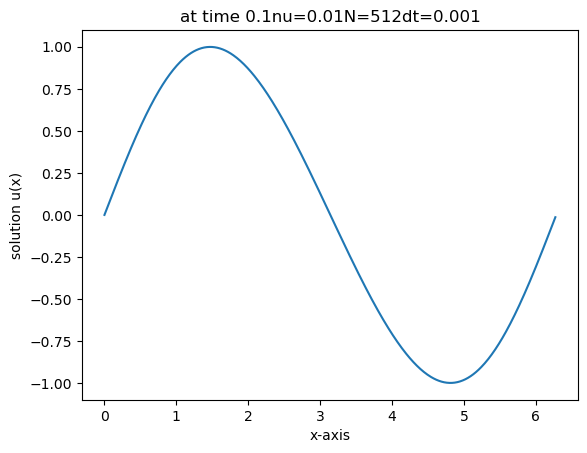

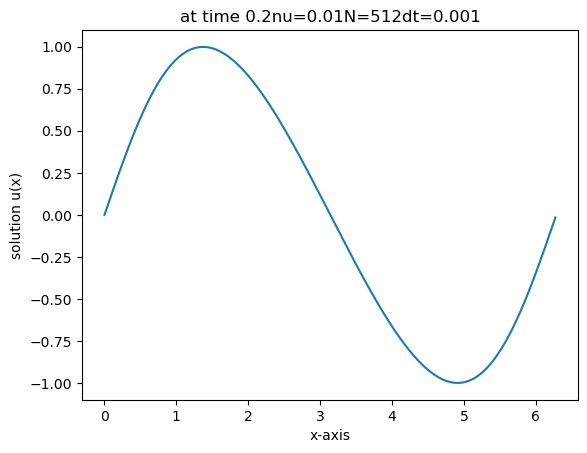

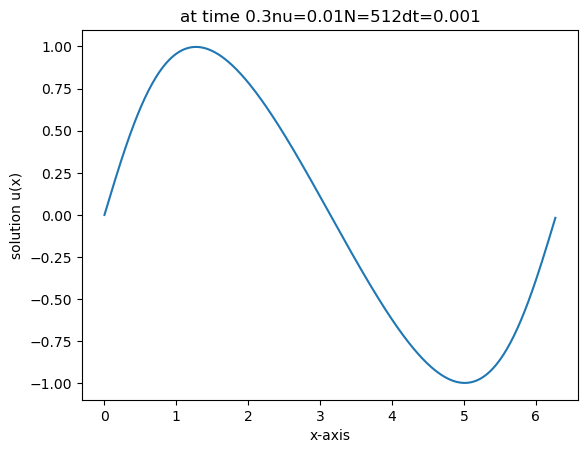

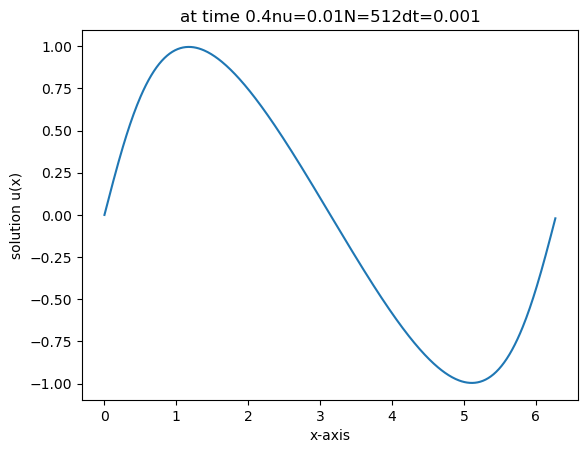

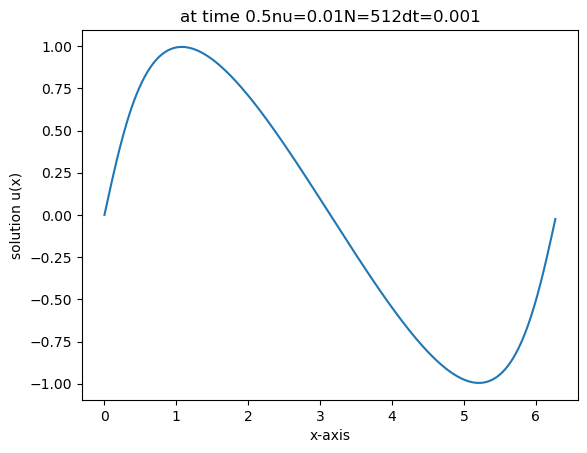

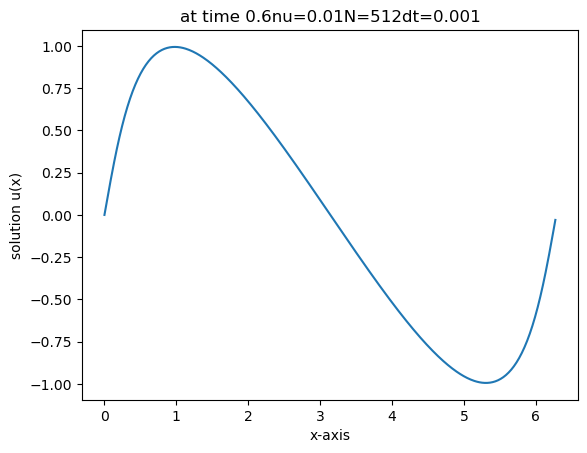

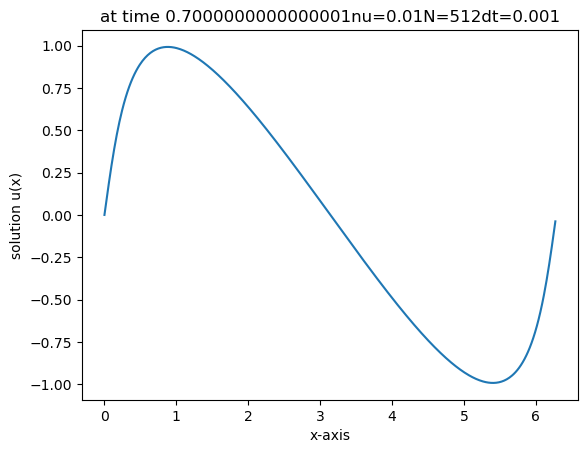

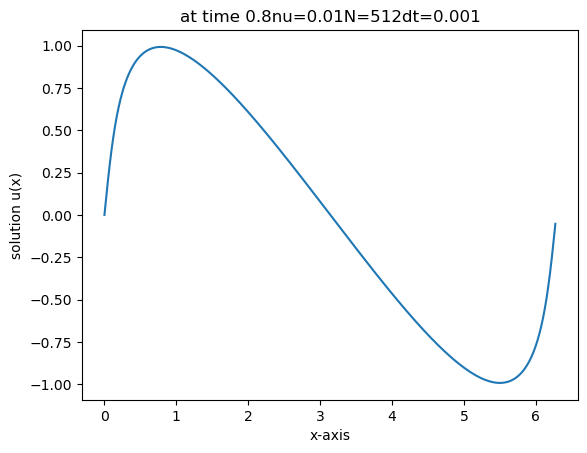

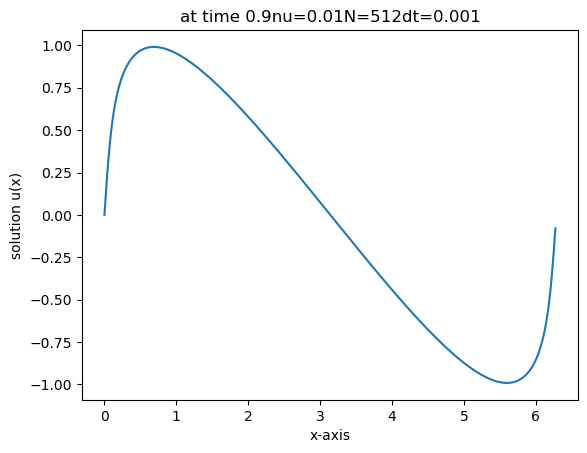

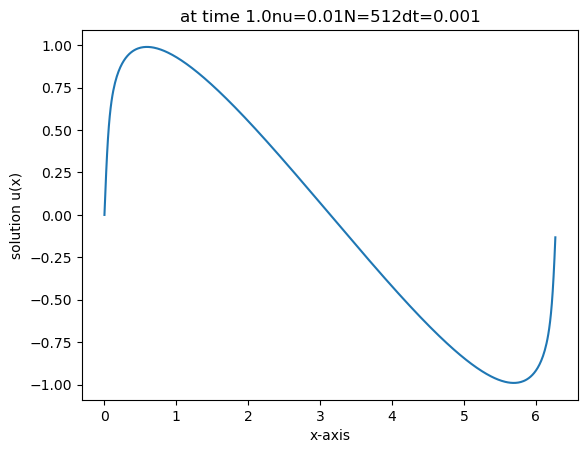

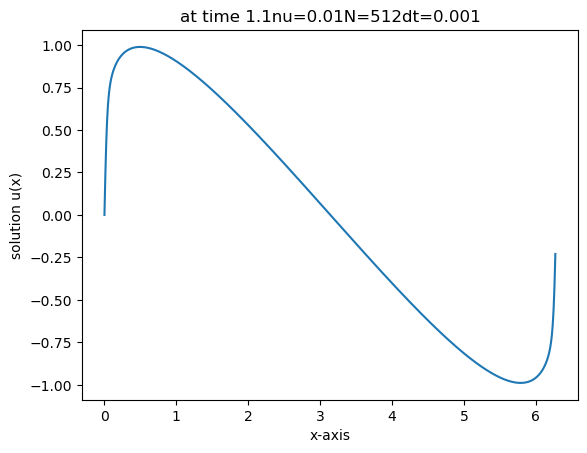

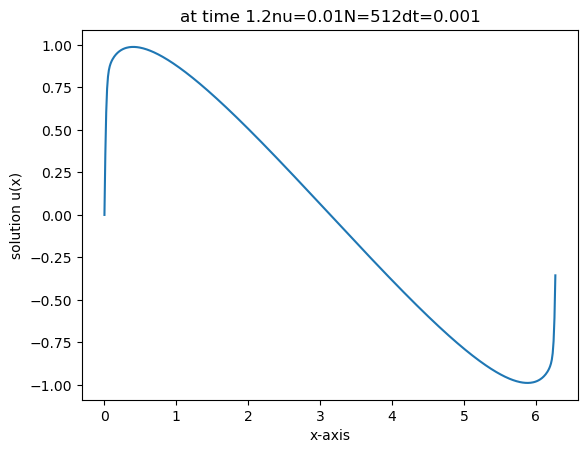

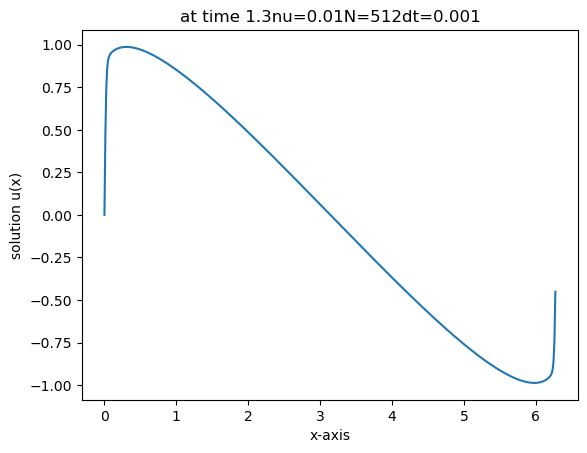

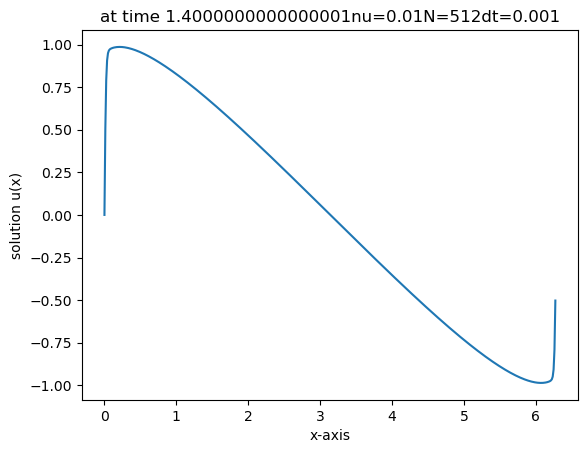

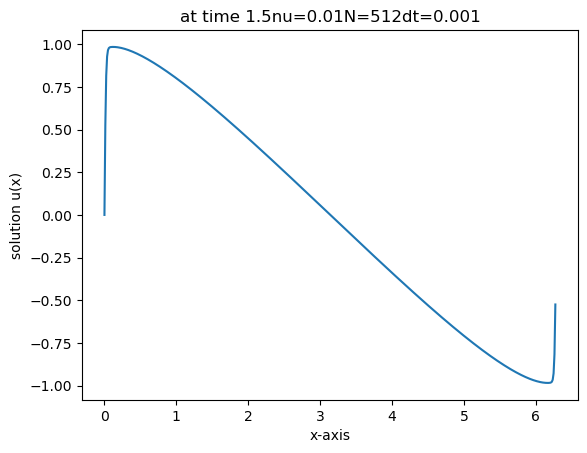

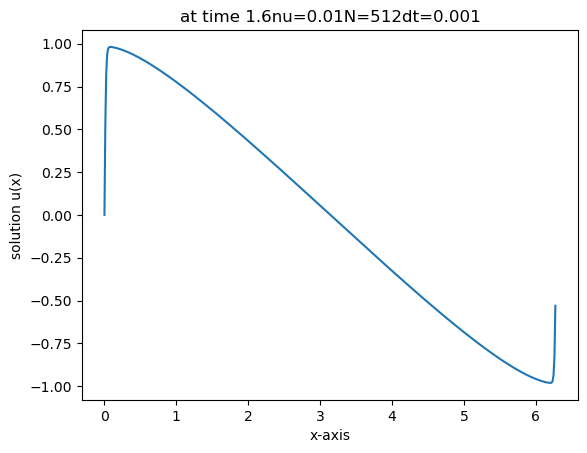

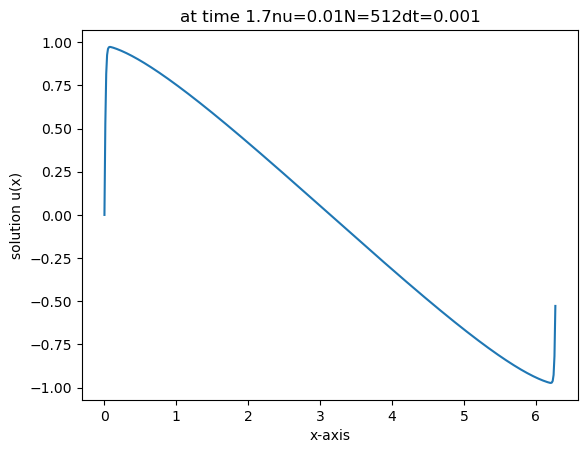

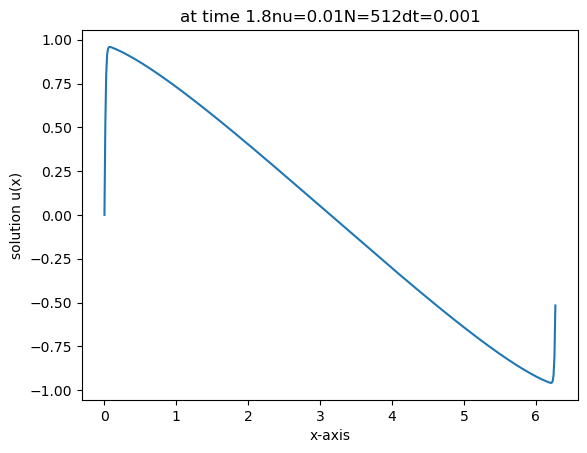

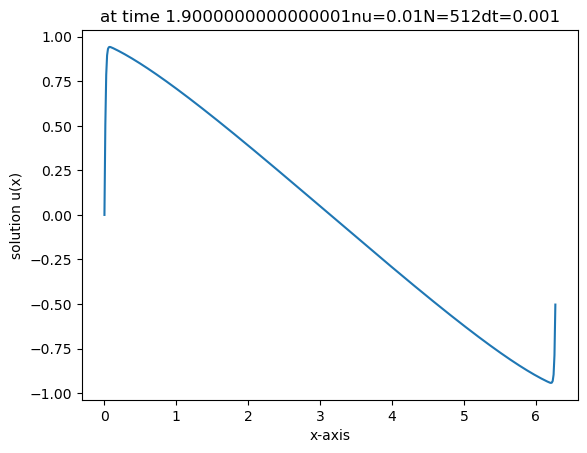

In [144]:
L=2*np.pi

N=2**9

nu=0.01

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-3)

s=10**2

no=2

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)

solutionplot(L,N,dt,Tmax,s,no,nu)

#captured shock well

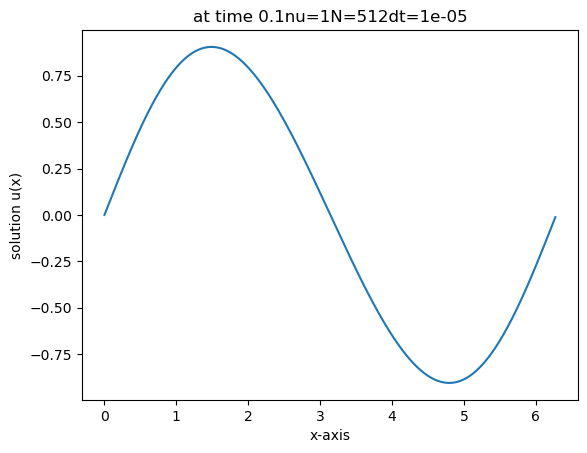

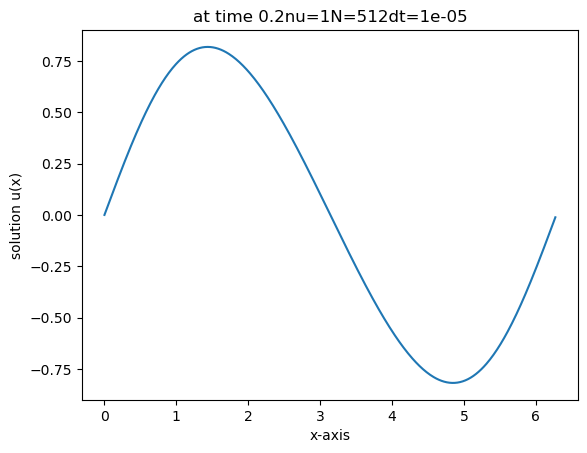

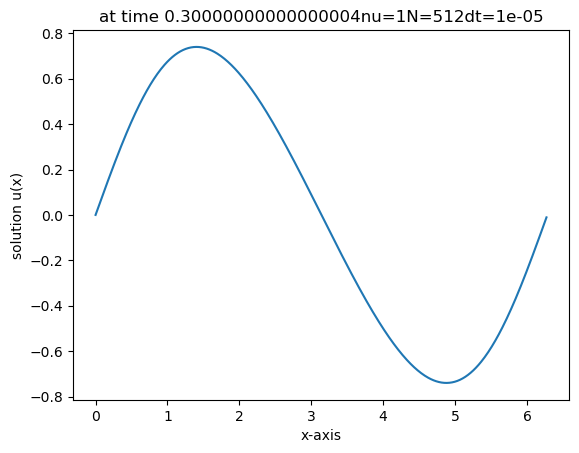

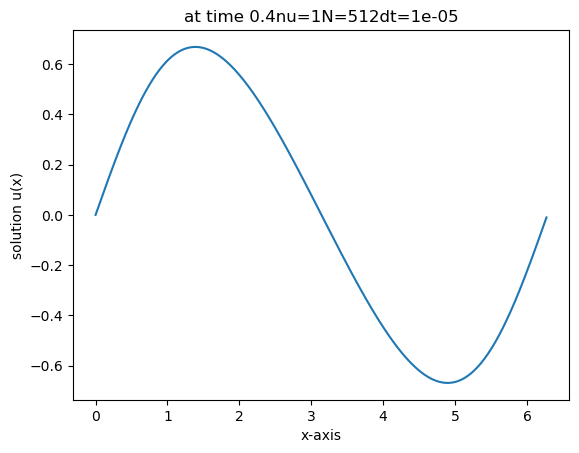

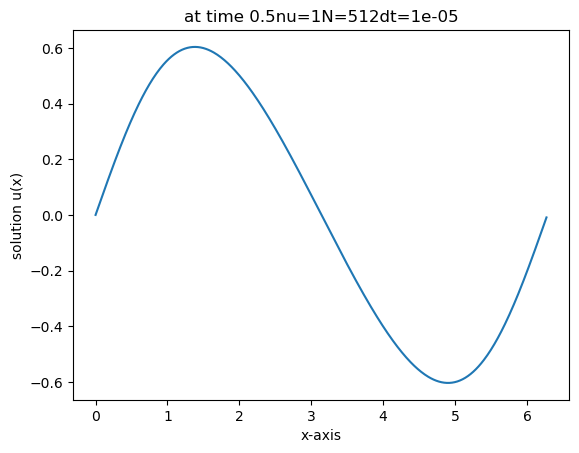

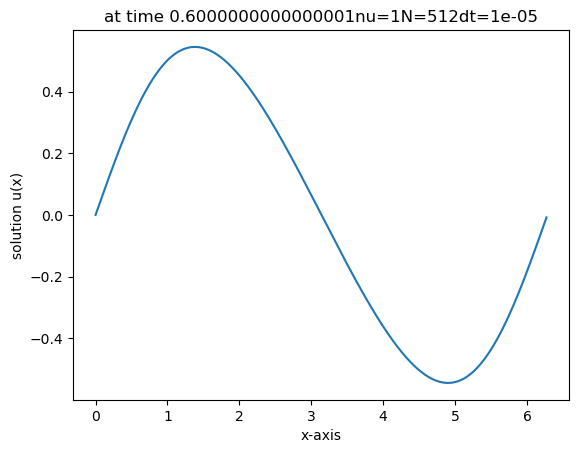

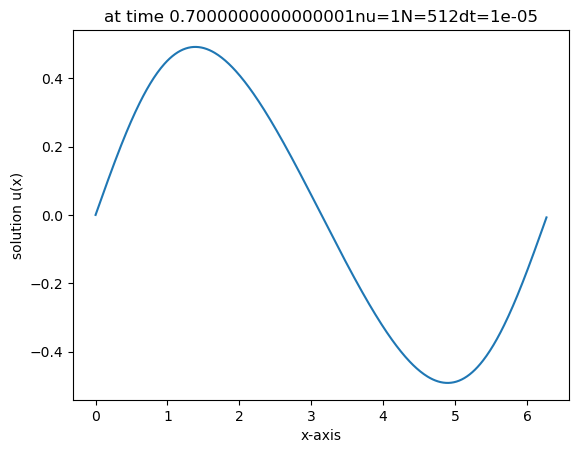

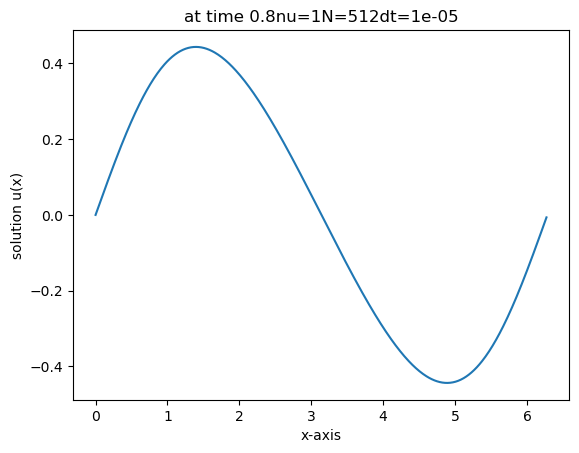

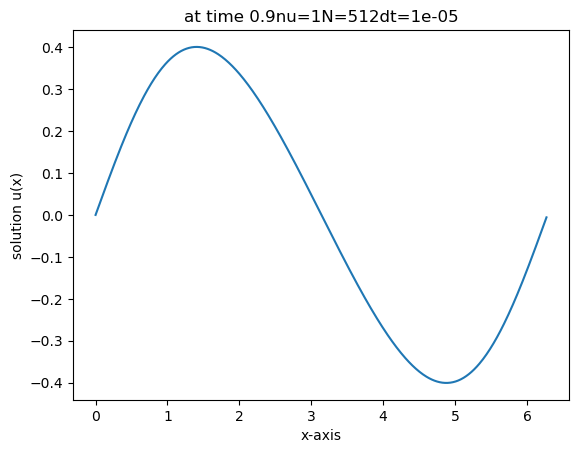

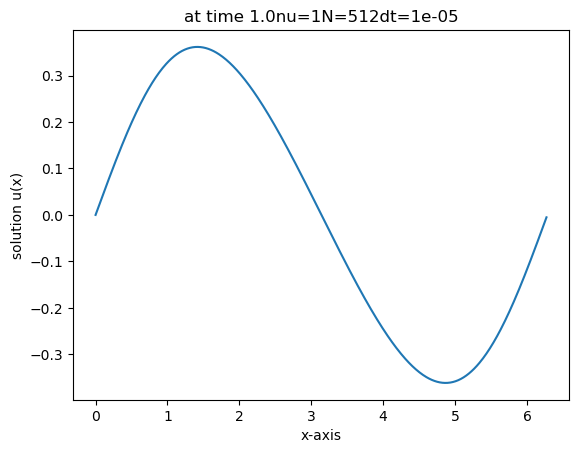

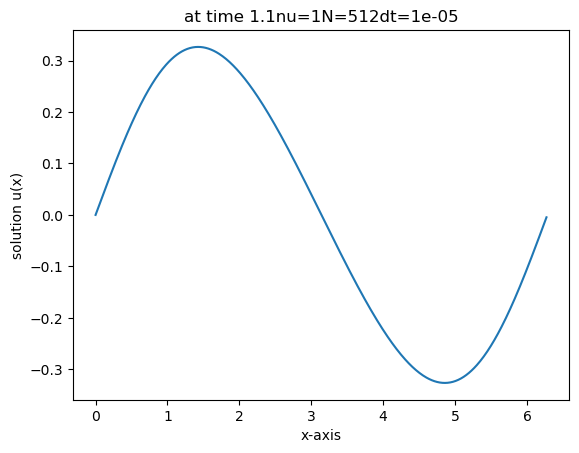

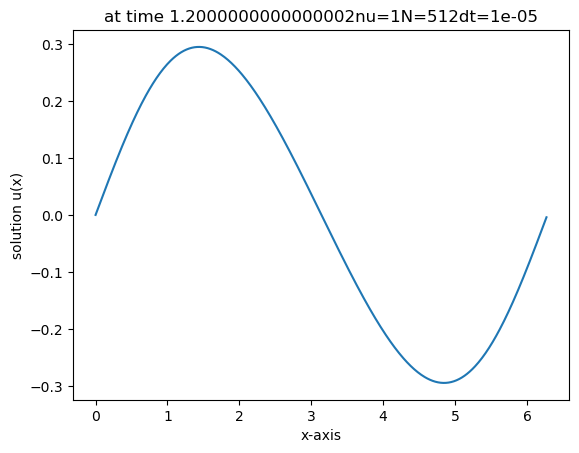

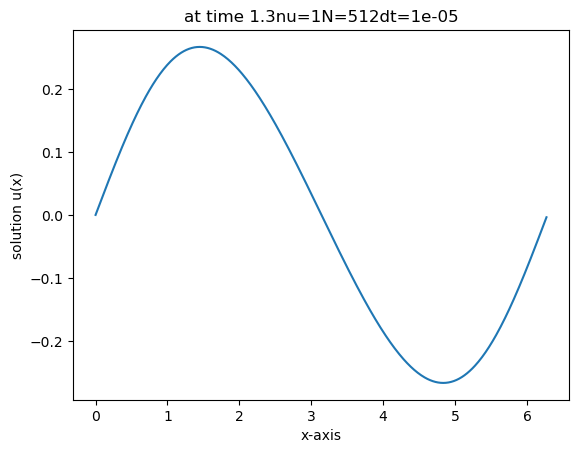

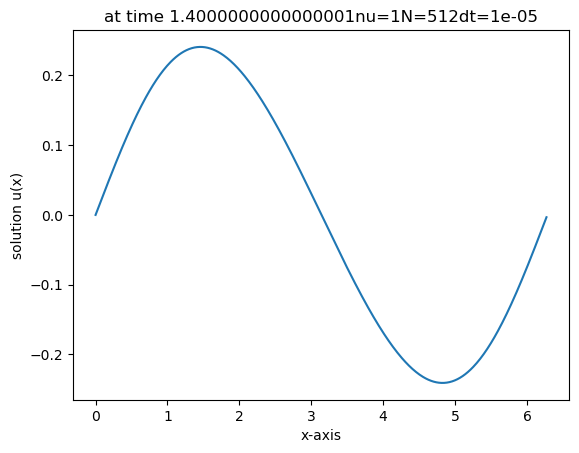

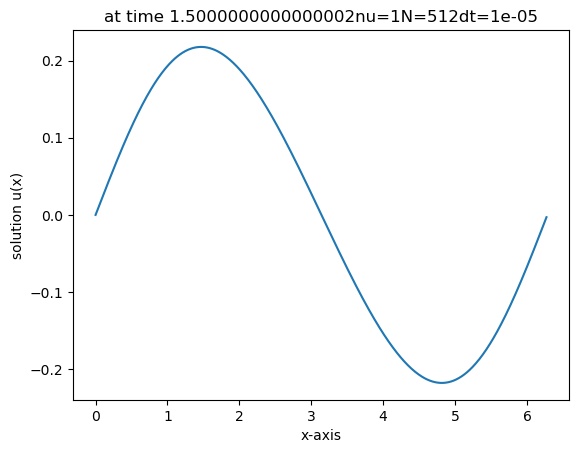

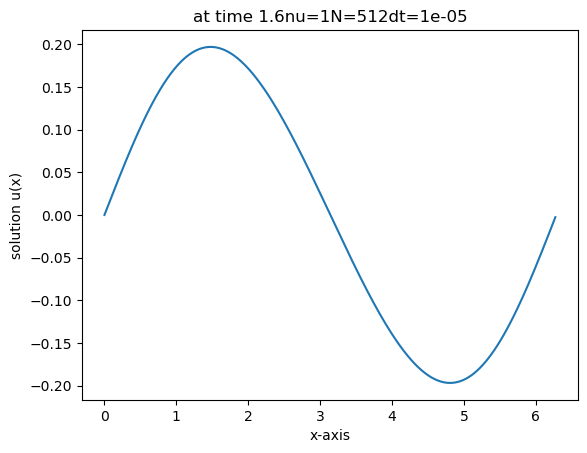

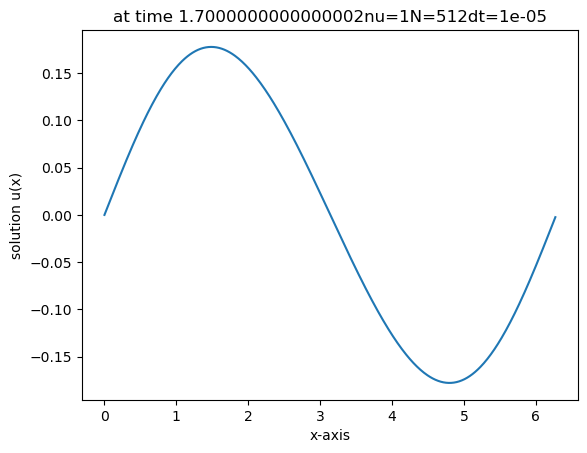

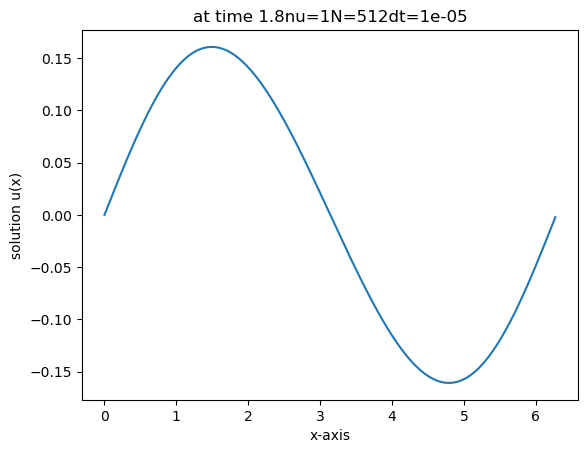

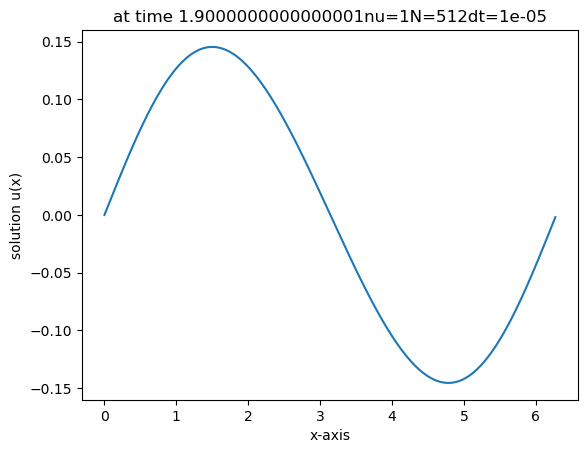

In [119]:
L=2*np.pi

N=2**9

nu=1

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-5)

s=10**4

no=1

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)

solutionplot(L,N,dt,Tmax,s,no,nu)

#here the shock formting term is dominated by diffusive term .So only have decay

In [11]:
#plotting fft(solution)

def fftsolutionplot(L,N,dt,Tmax,s,no,nu):
    
    dx=L/N #space-spacing
    x=np.arange(0,L,dx) #space points
    k=fftfreq(N,1/N)*(2*np.pi)/L #wave numbers
    kmax=int(np.max(k))
    k_positive=k[:kmax+1]
    
    Nt=round(Tmax/dt) #number of time steps
    t=np.arange(0,Tmax,dt) #time points
    
    for i in range(0,Nt):
        
        #print(str(i)+" ",end='')
        
        if i%s==0:
            
            ti=t[i] #present time
            uk=np.load('/localhome/souryajit/Desktop/mycodes/nlpde/solution/uk'+str(no)+'_'+str(i)+'.npy')
            uk_positive=uk[:kmax+1]
            plt.plot(k_positive,np.abs(uk_positive))
            plt.title('at time '+str(ti)+'nu='+str(nu)+'N='+str(N)+'dt='+str(dt))
            plt.xlabel('k_positive')
            plt.xlim(0,50)
            plt.ylabel('|uk|')
            plt.show()
            plt.close()


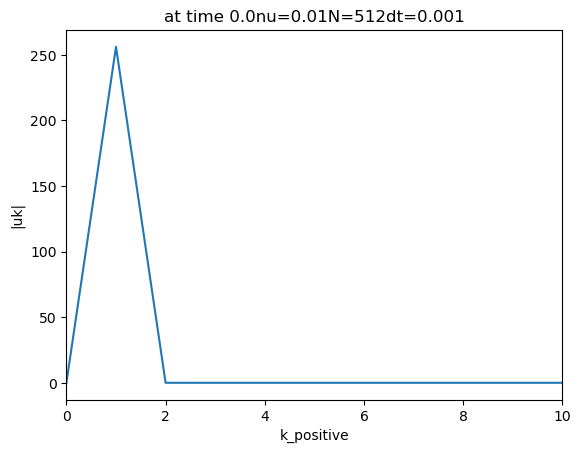

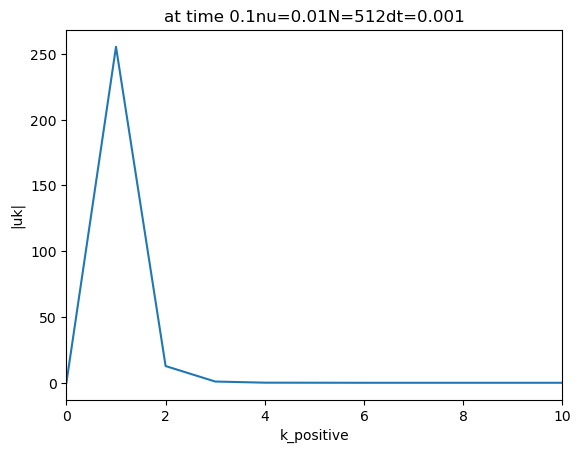

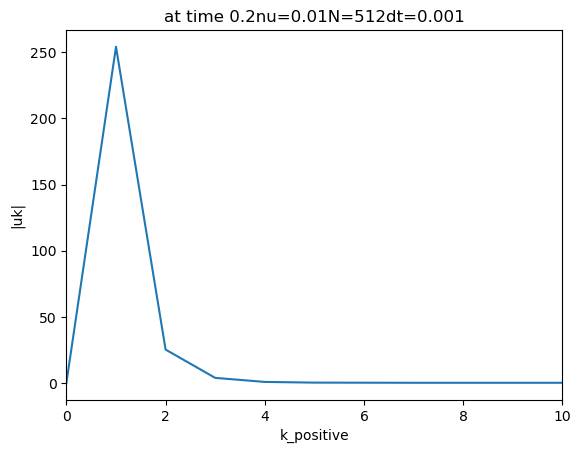

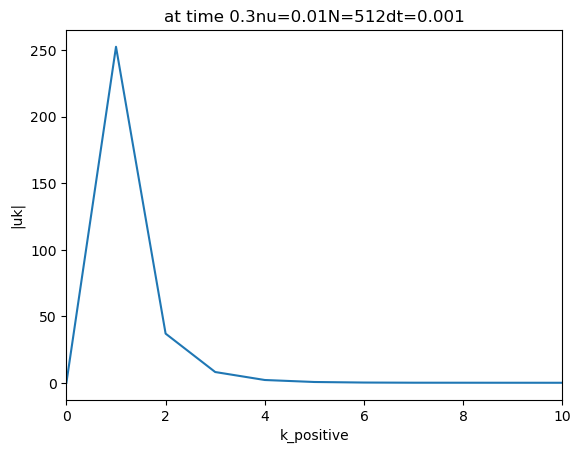

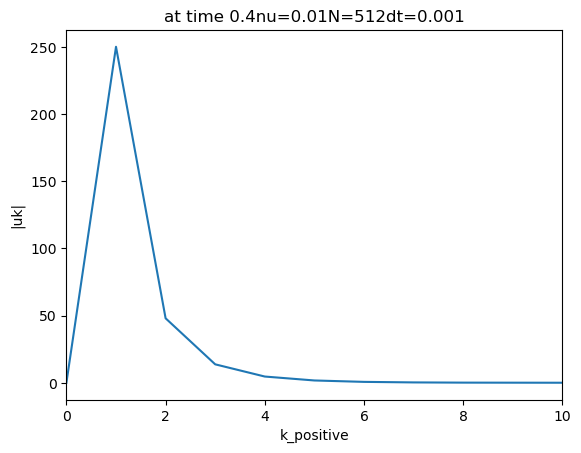

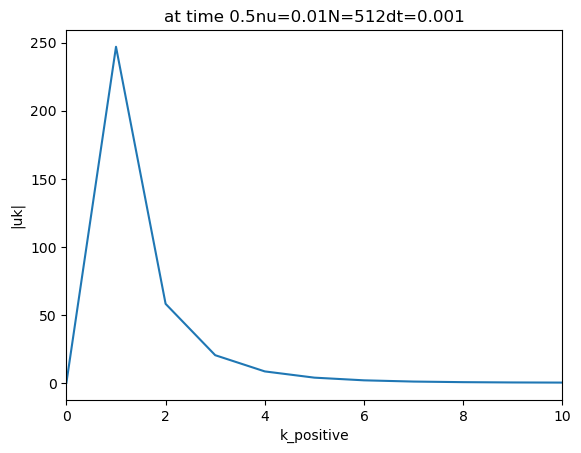

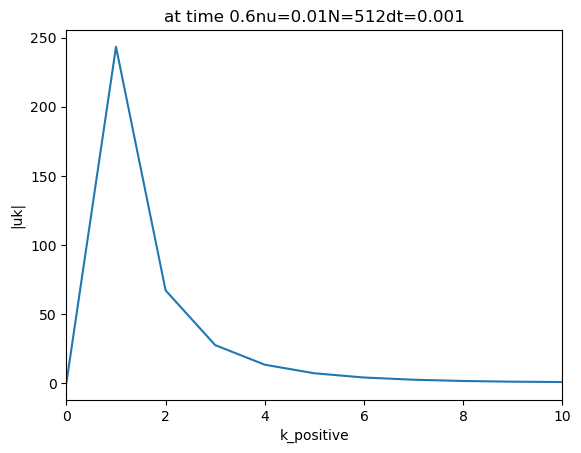

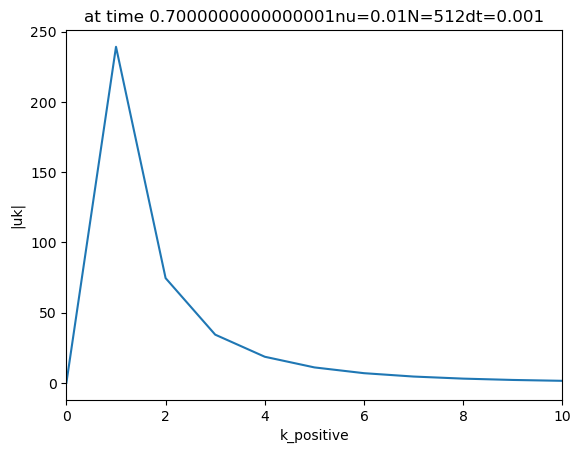

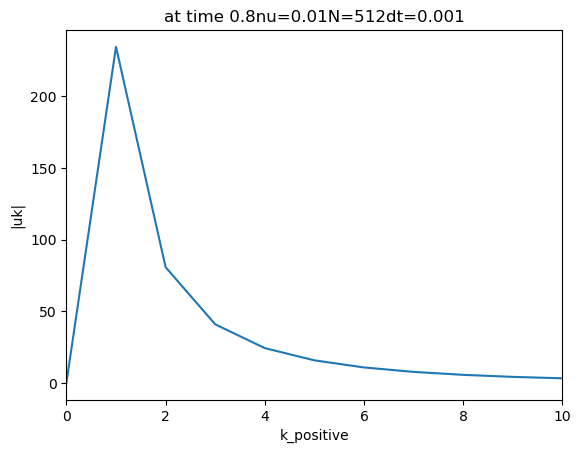

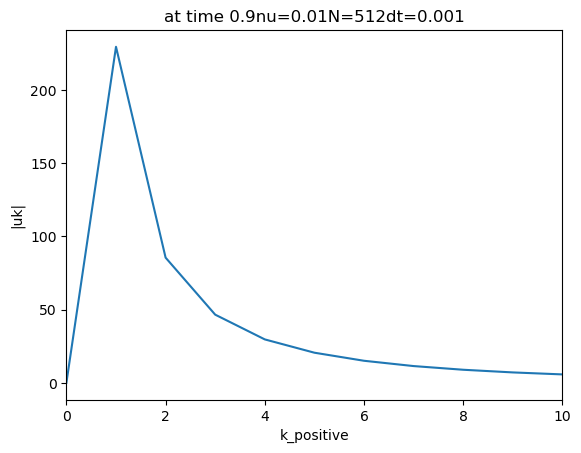

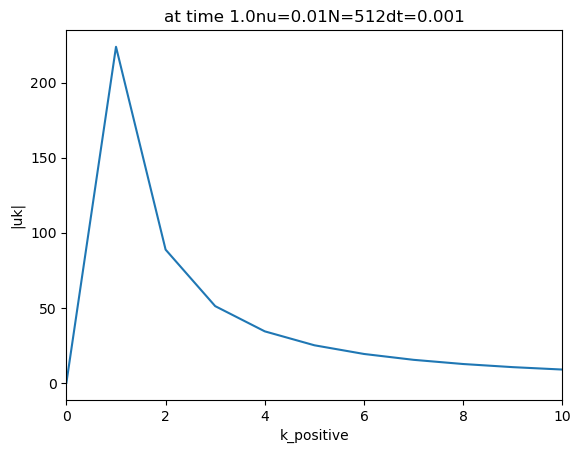

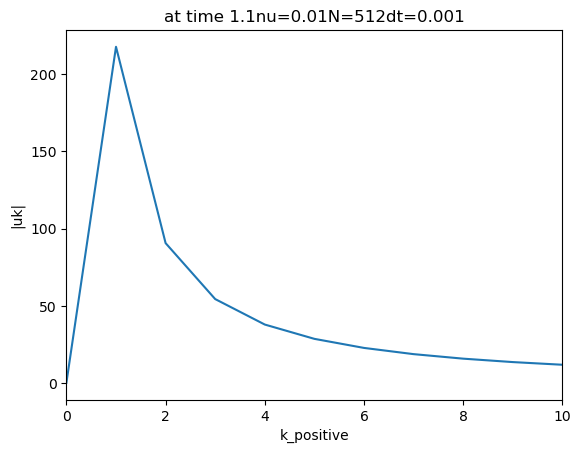

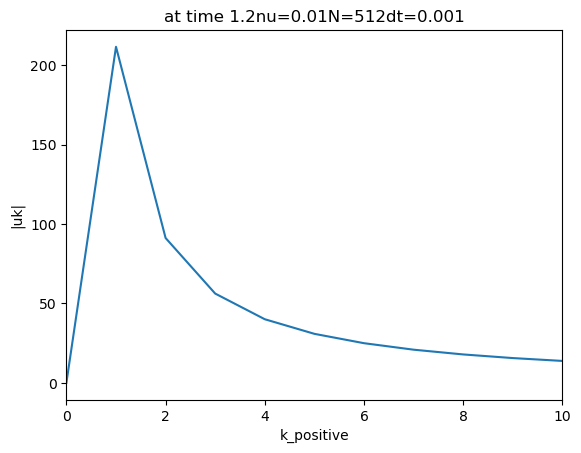

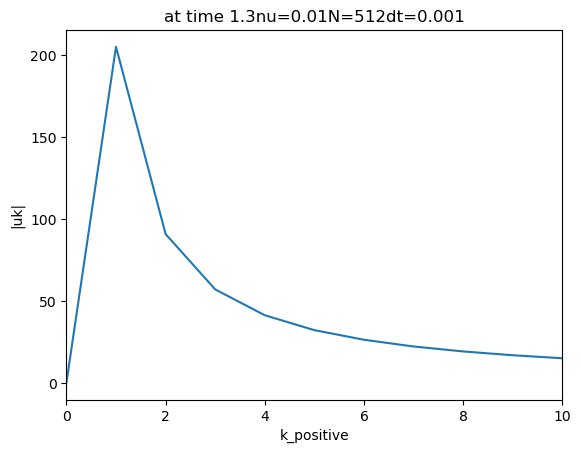

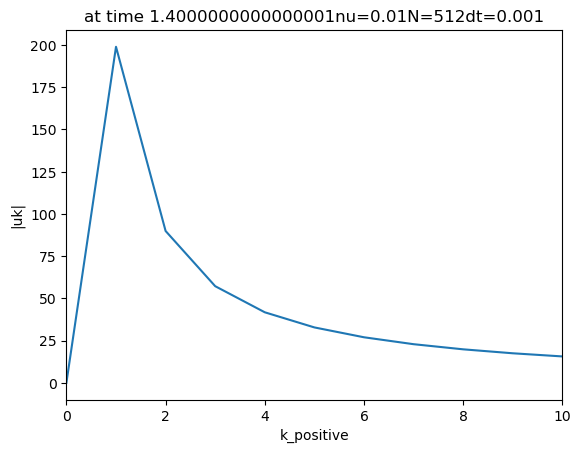

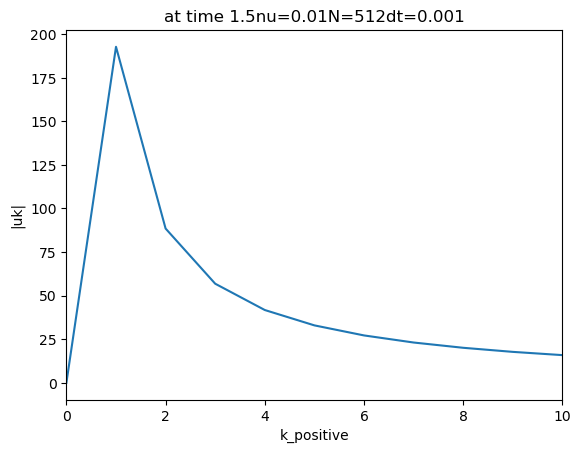

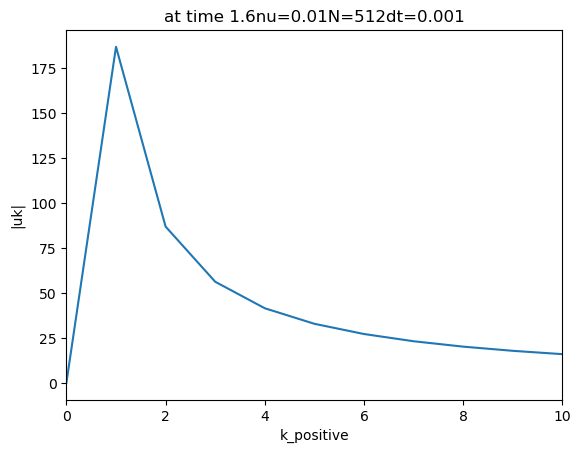

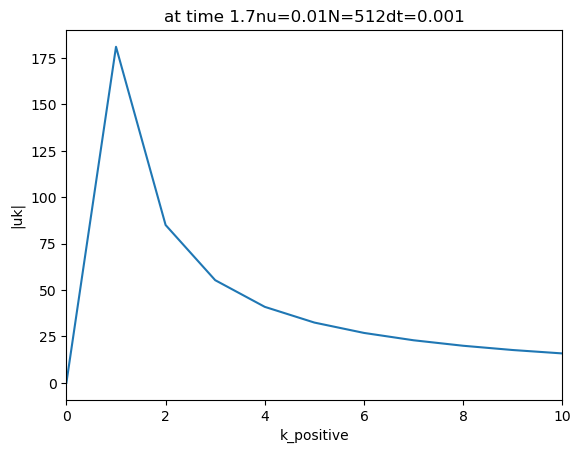

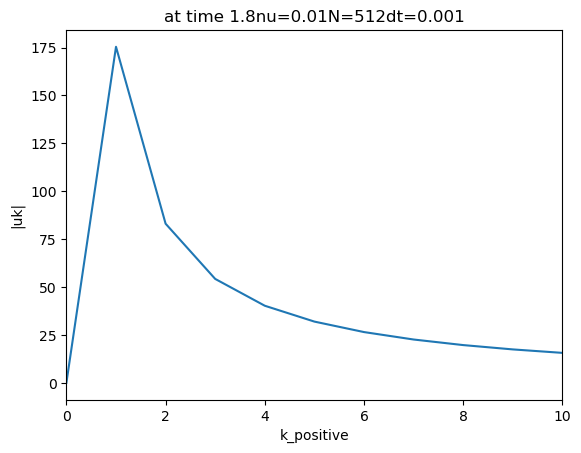

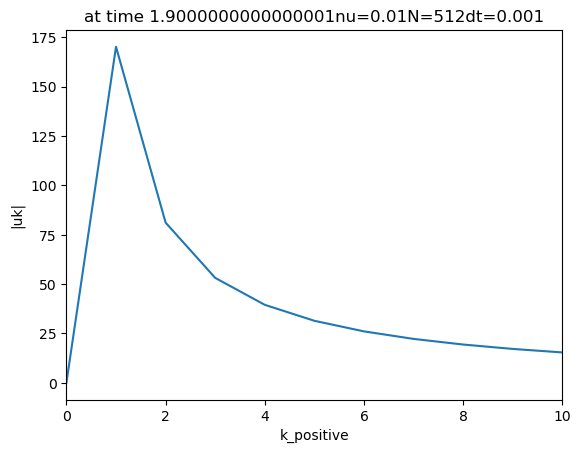

In [175]:
L=2*np.pi

N=2**9

nu=0.01

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-3)

s=10**2

no=2

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)

fftsolutionplot(L,N,dt,Tmax,s,no,nu)

#decay is good except one wave number peak which is expected. Because it is a line plot it joined the peak with the rest and got a increase in beginning which is actually not

In [ ]:
# IV (a)

L=2*np.pi

N=2**10

nu=1

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-3)

s=10**2

no=1

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)


burger_solve(L,N,nu,u0k,Tmax,dt,s,no,p)

#blow up happened after 366 steps.cfl error !

In [ ]:
L=2*np.pi

N=2**10

nu=1

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-4)

s=10**3

no=3

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)


burger_solve(L,N,nu,u0k,Tmax,dt,s,no,p)

#blow up happened afteer 382 steps.CFL error!


In [ ]:


L=2*np.pi

N=2**10

nu=1

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-5)

s=10**4

no=3

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)


burger_solve(L,N,nu,u0k,Tmax,dt,s,no,p)

In [ ]:
L=2*np.pi

N=2**10

nu=1

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-5)

s=10**4

no=4

dx=L/N

x=np.arange(0,L,dx)

u0=1+np.sin(x)+np.cos(x)

u0k=fft(u0)


burger_solve(L,N,nu,u0k,Tmax,dt,s,no,p)

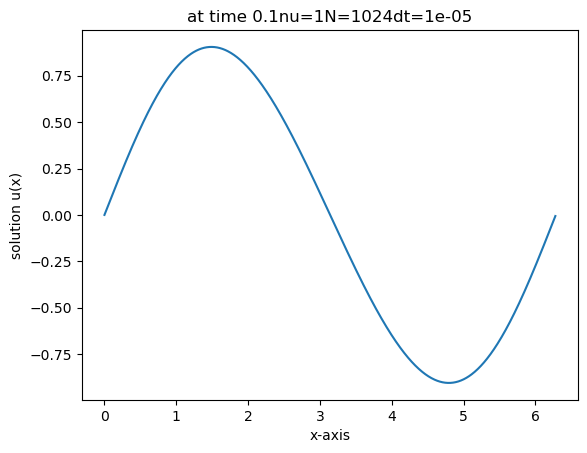

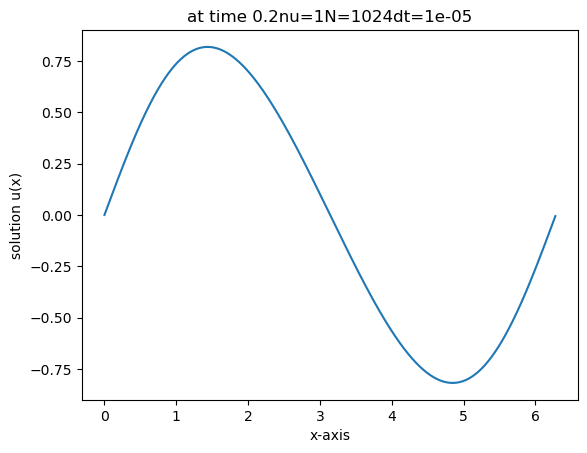

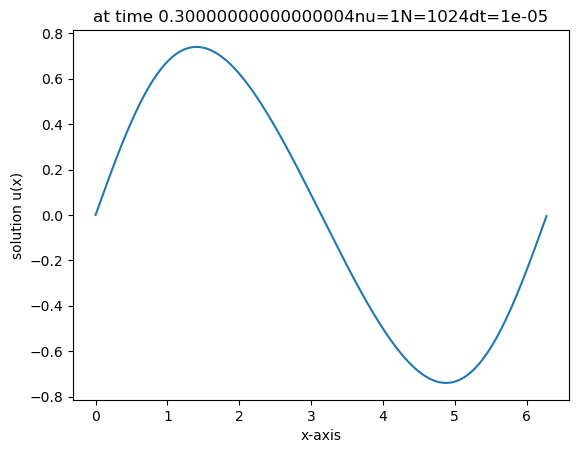

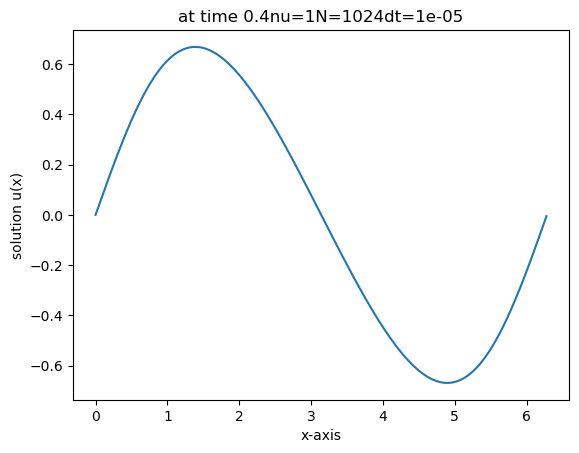

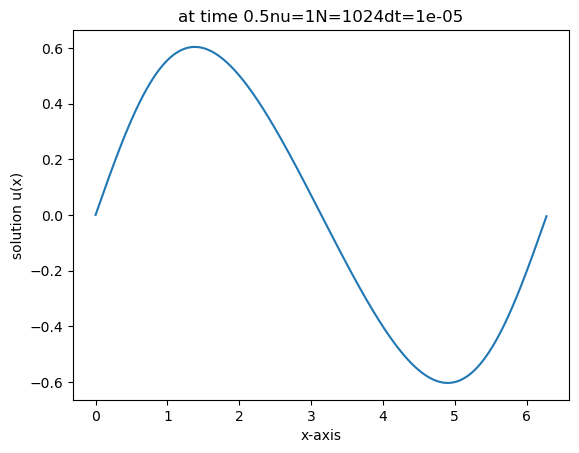

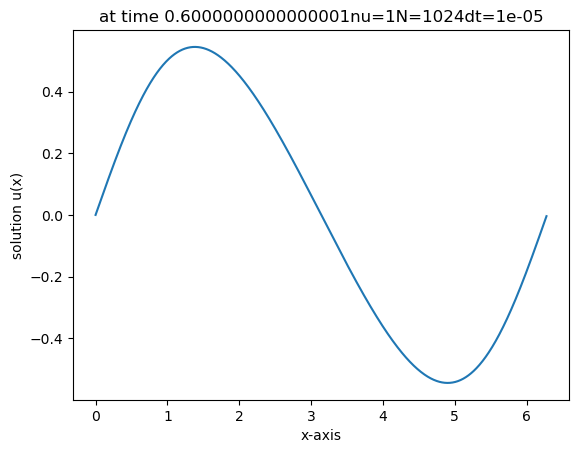

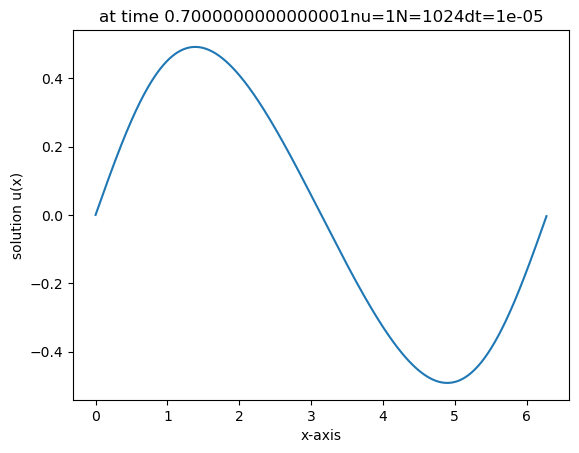

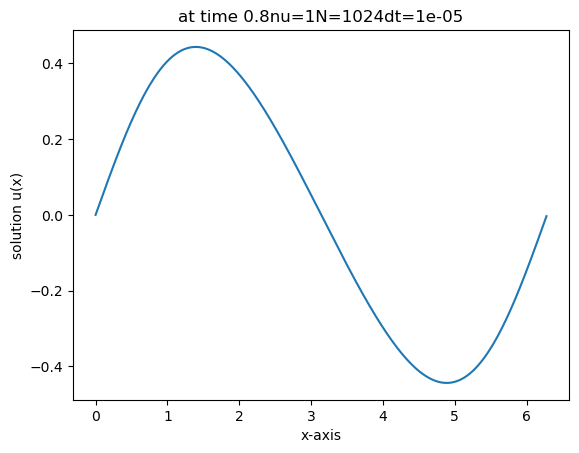

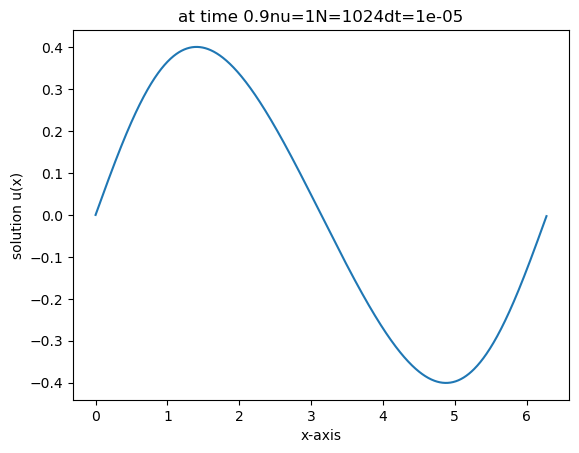

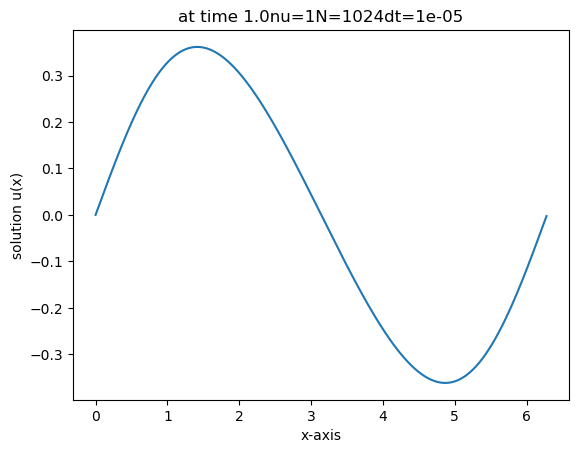

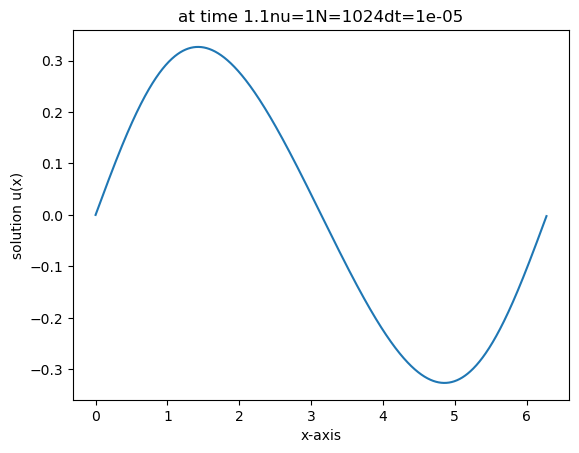

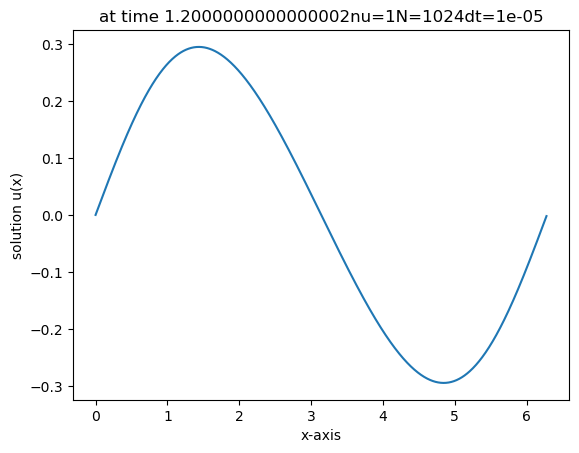

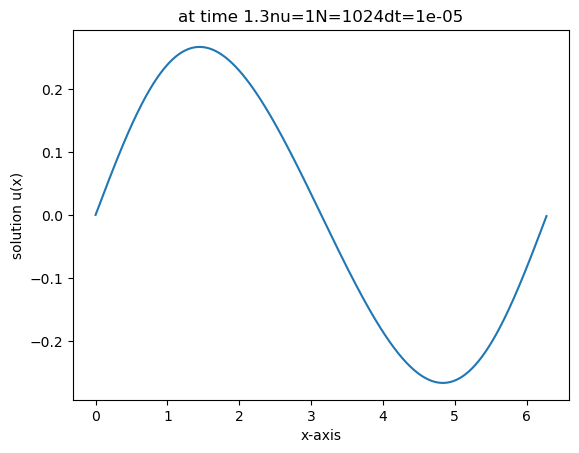

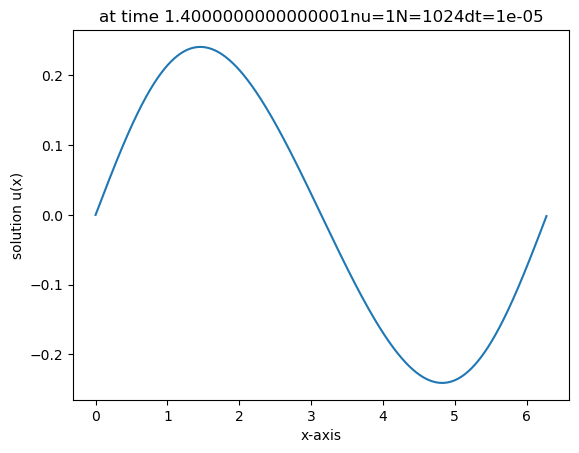

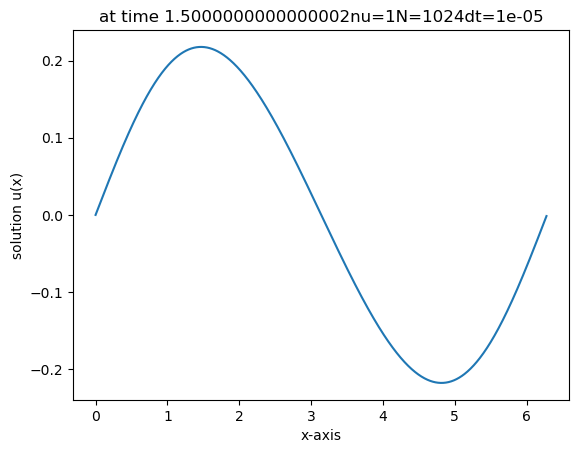

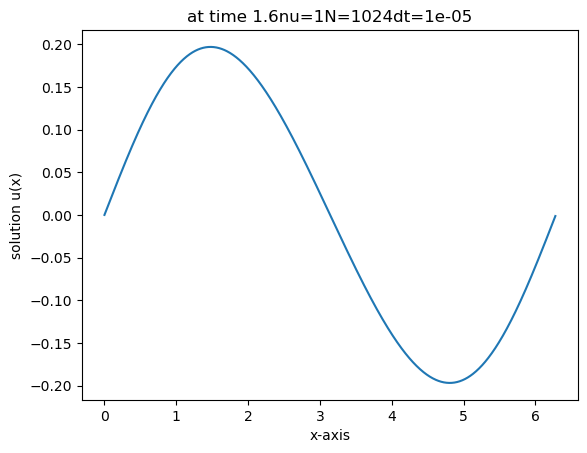

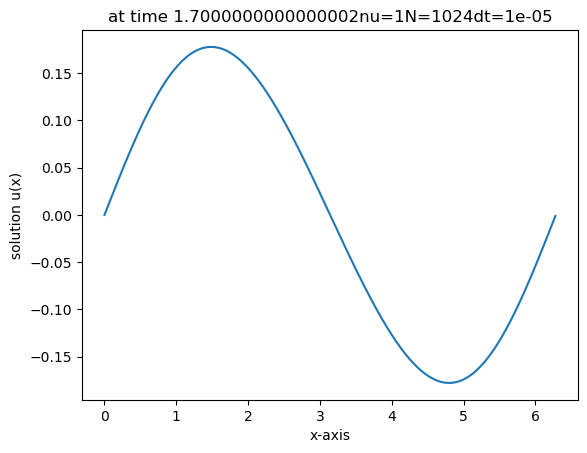

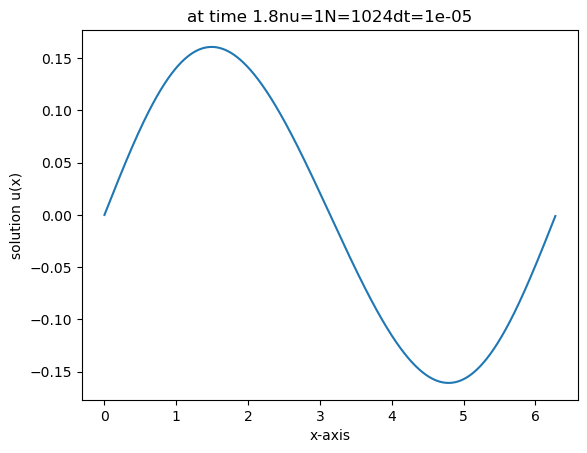

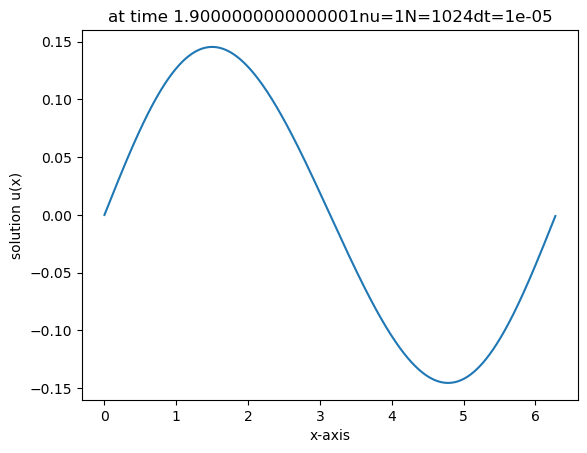

In [181]:
L=2*np.pi

N=2**10

nu=1

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-5)

s=10**4

no=3

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)

solutionplot(L,N,dt,Tmax,s,no,nu)

#no visible shocks, expect same peaks in fourier plpot

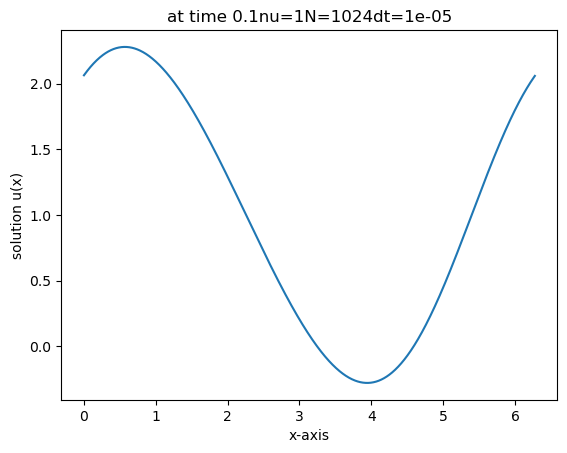

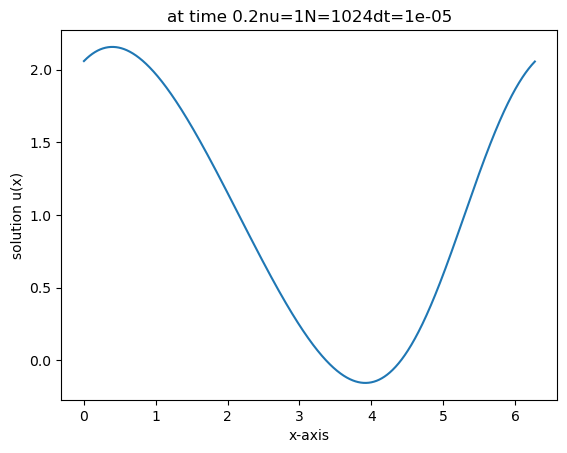

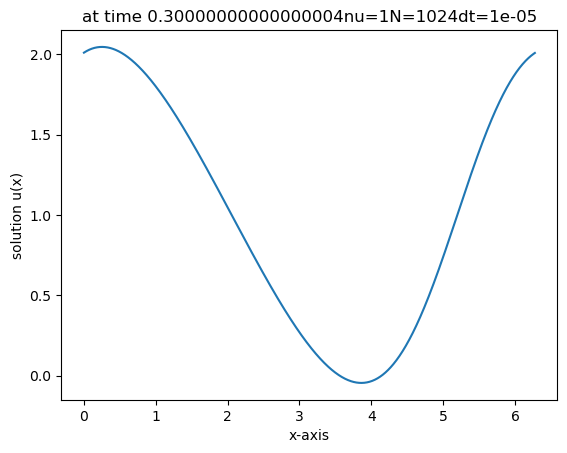

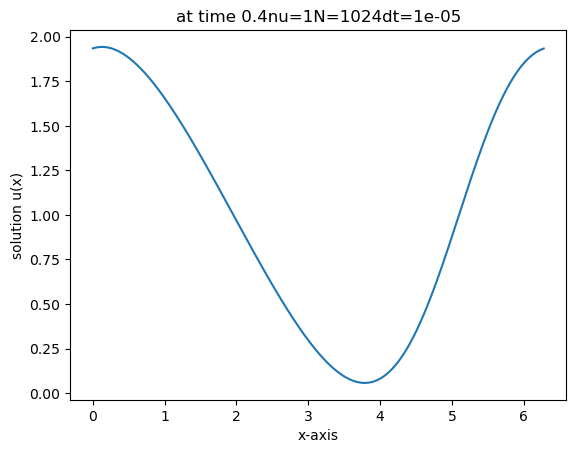

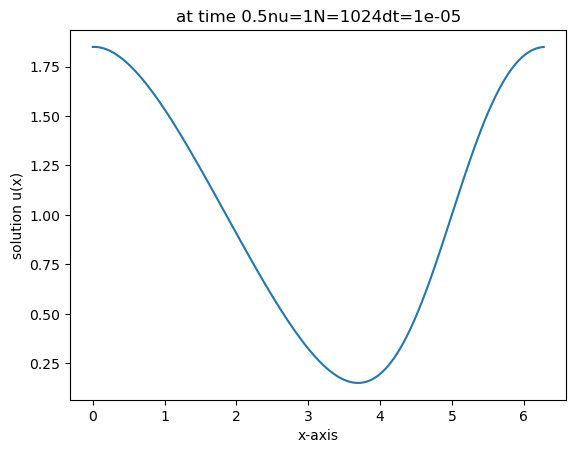

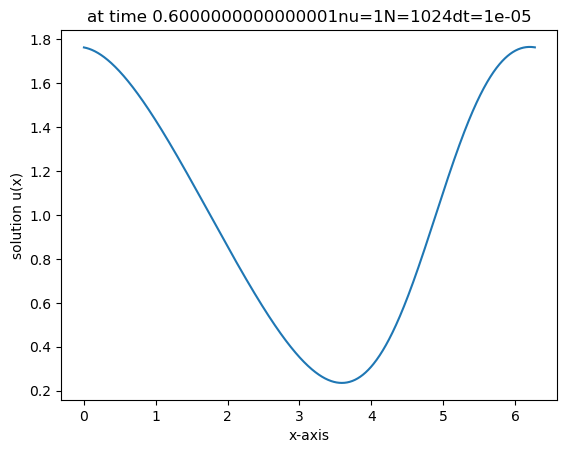

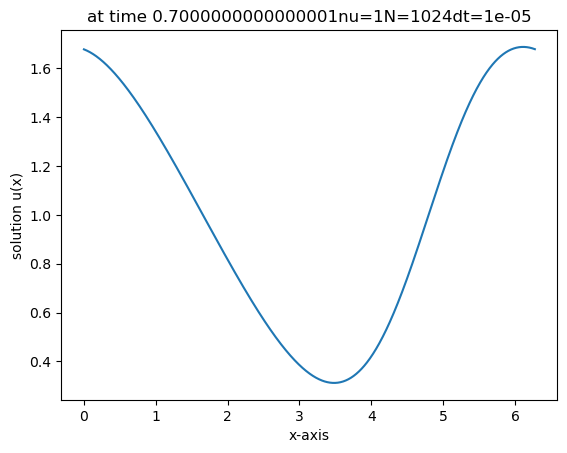

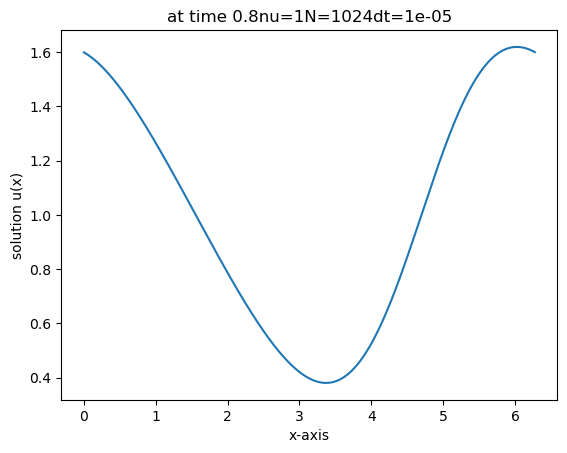

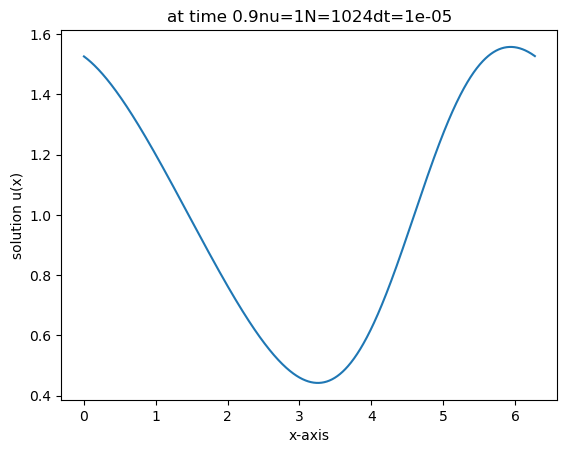

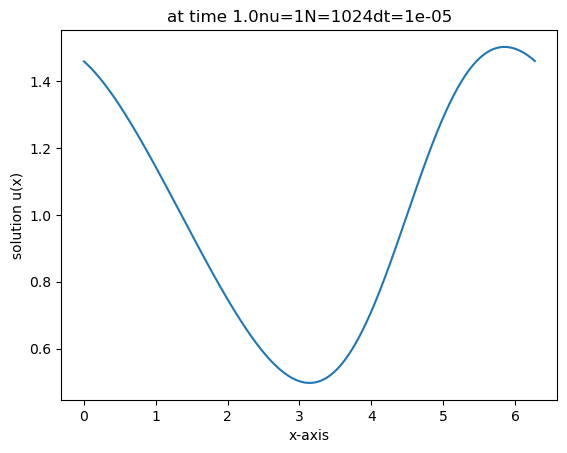

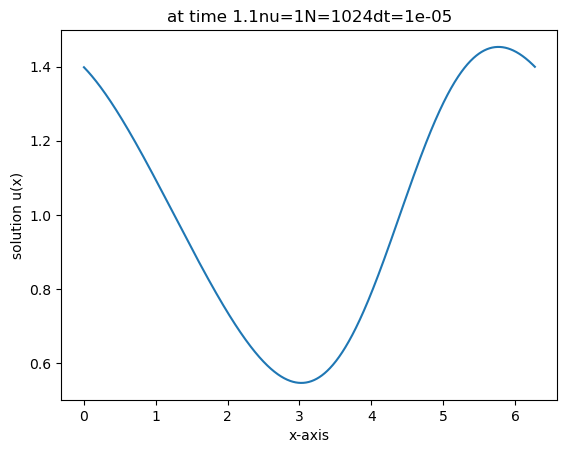

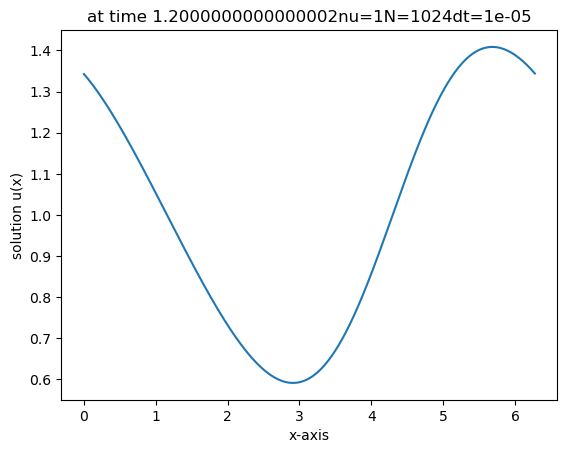

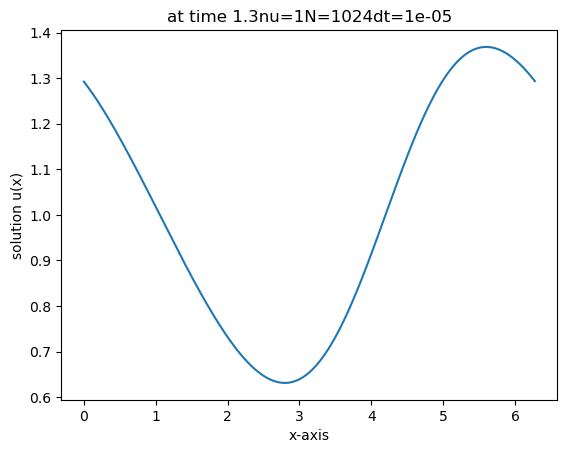

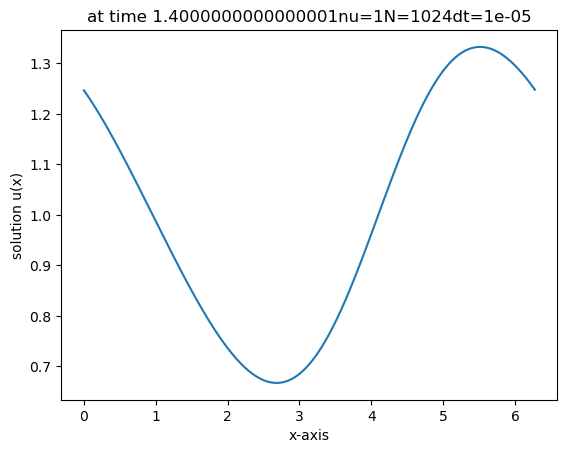

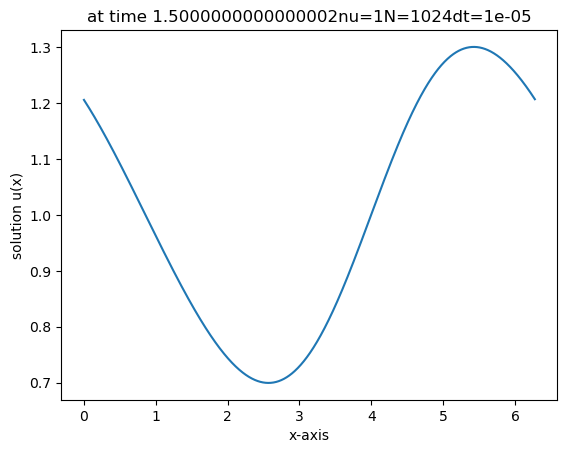

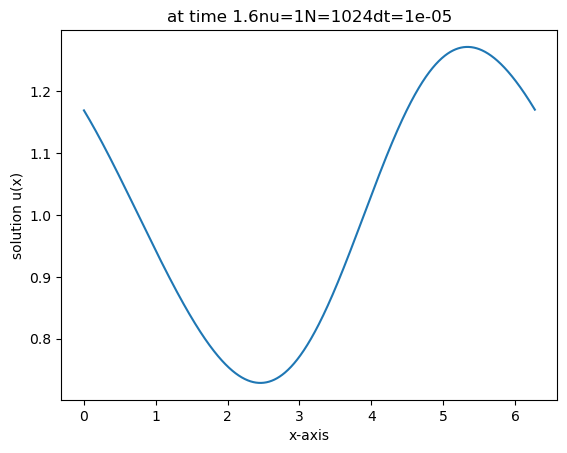

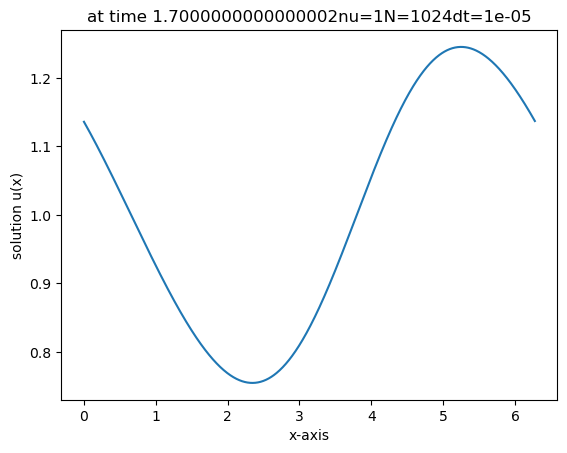

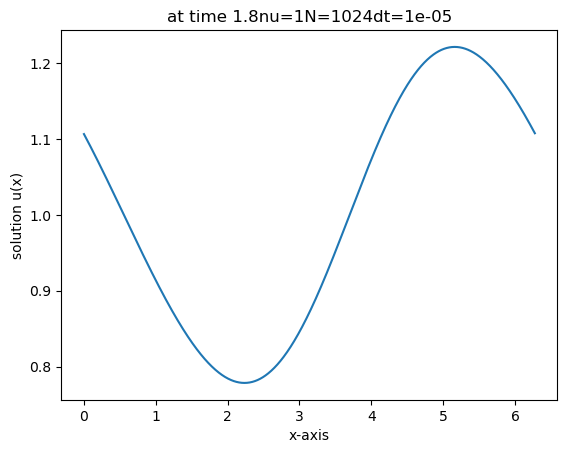

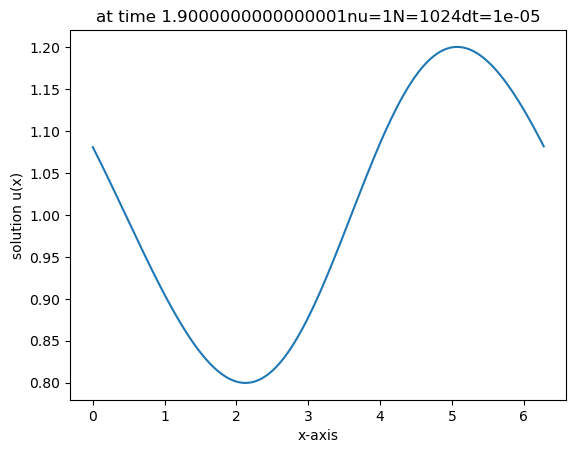

In [180]:
#plotting solution for non blow up

L=2*np.pi

N=2**10

nu=1

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-5)

s=10**4

no=4

dx=L/N

x=np.arange(0,L,dx)

u0=1+np.sin(x)+np.cos(x)

u0k=fft(u0)

solutionplot(L,N,dt,Tmax,s,no,nu)

#no visible shocks,only decay, expect same peaks in fourier plpot

#no shocks again 

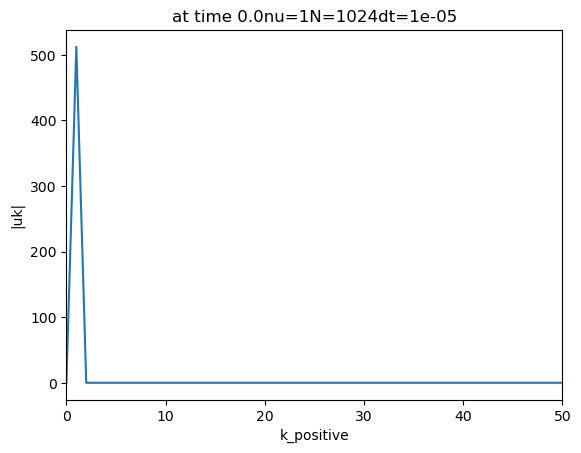

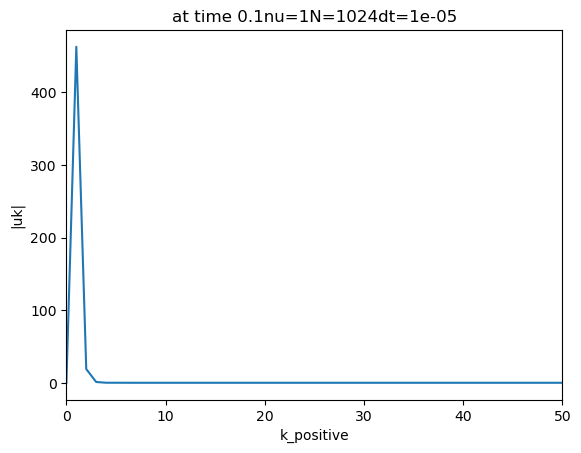

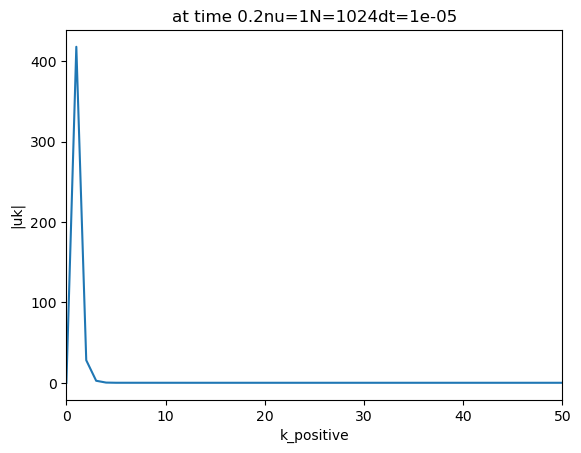

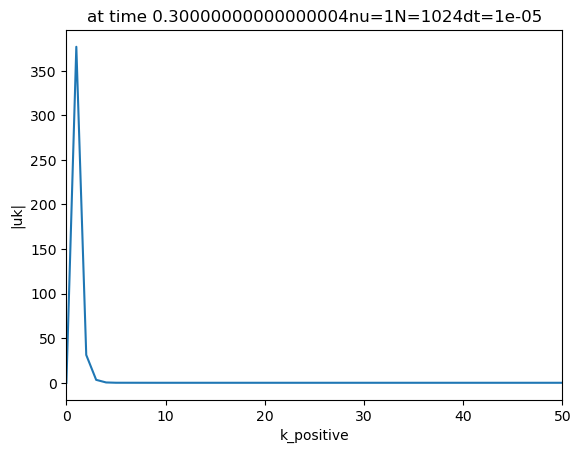

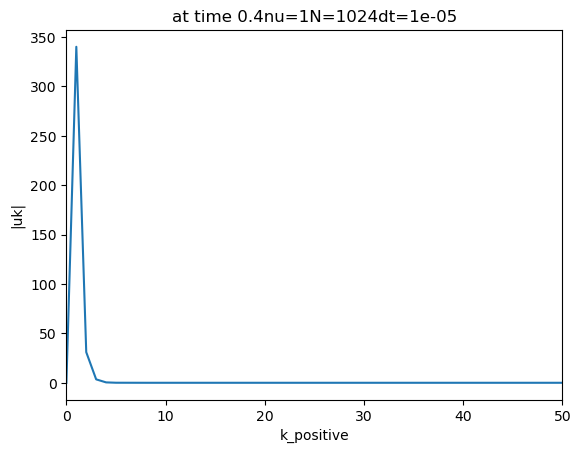

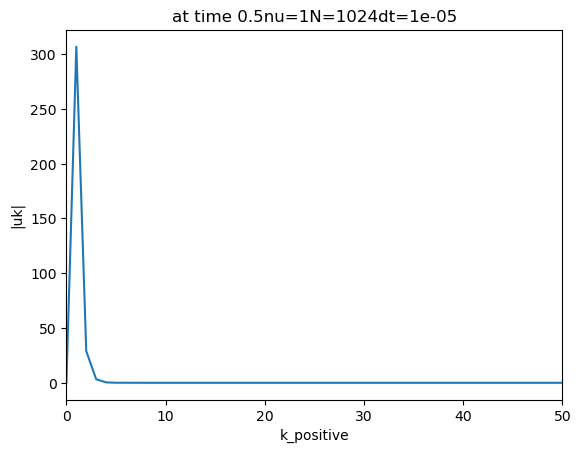

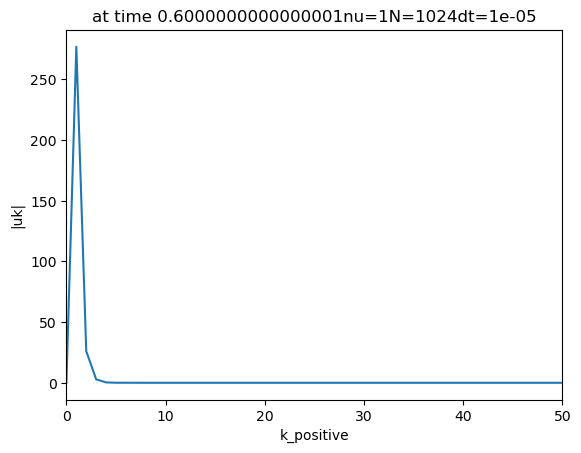

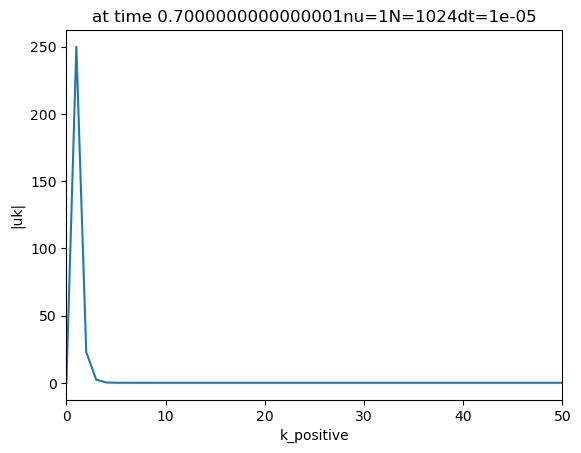

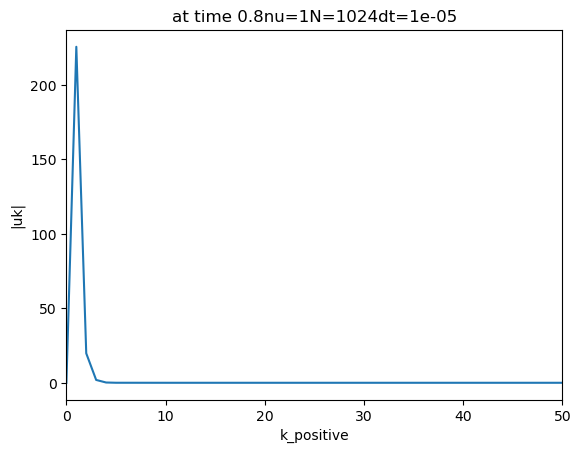

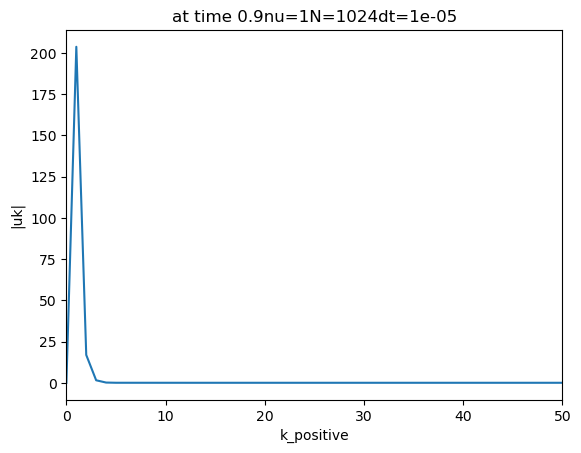

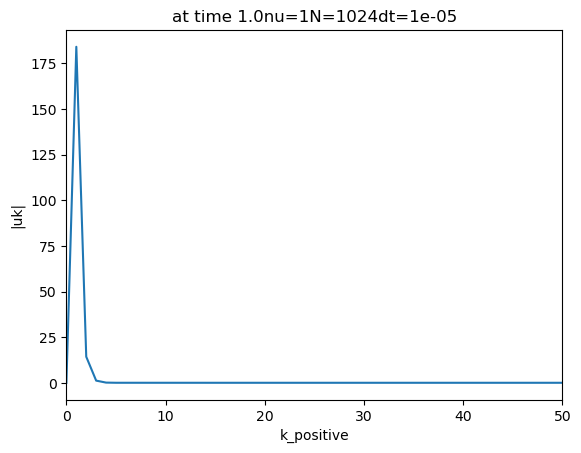

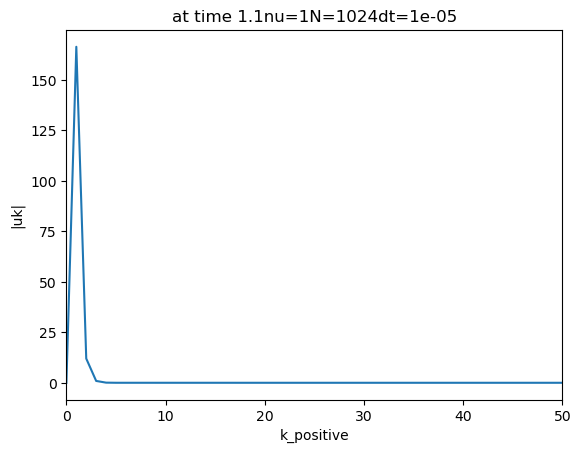

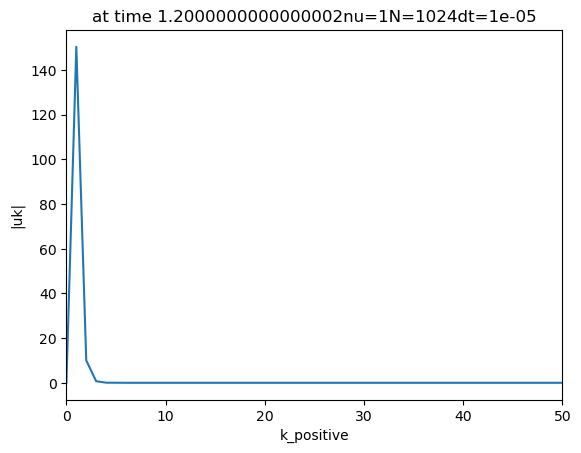

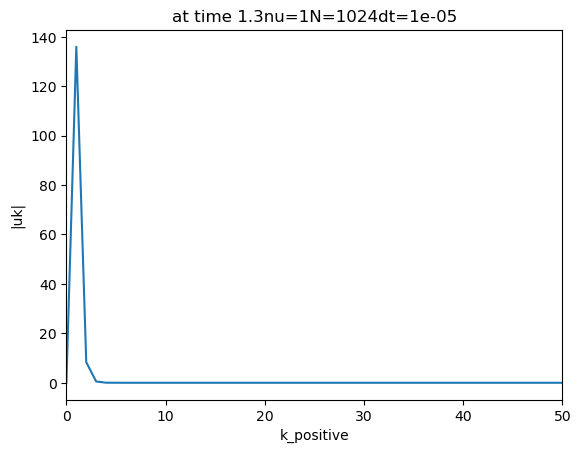

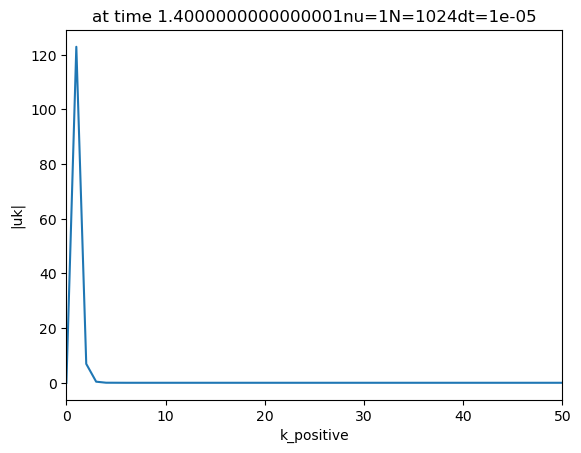

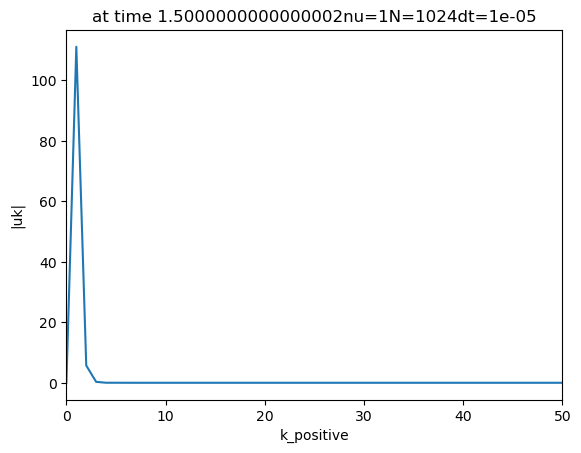

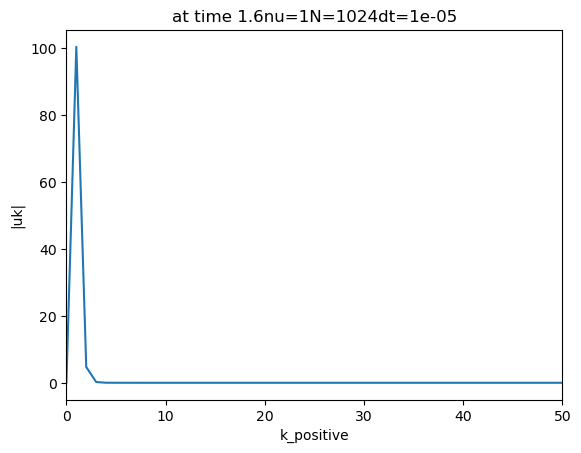

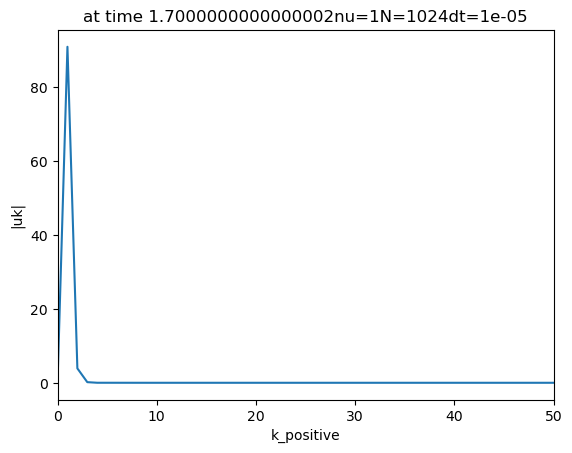

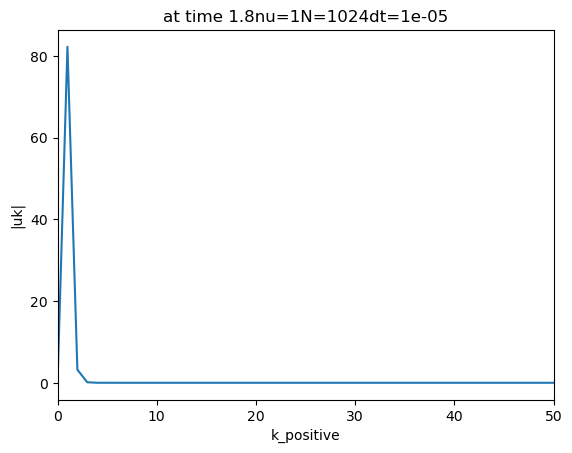

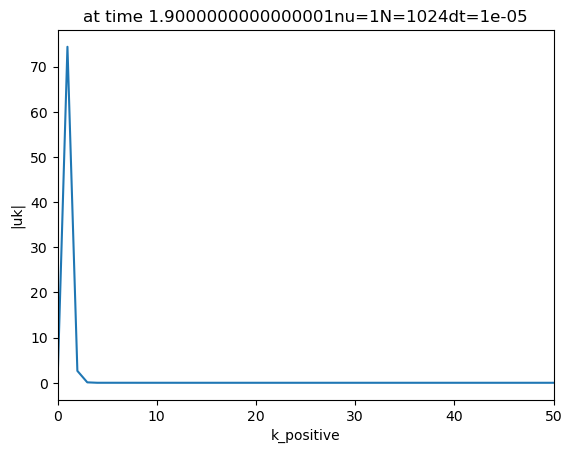

In [178]:
L=2*np.pi

N=2**10

nu=1

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-5)

s=10**4

no=3

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)

fftsolutionplot(L,N,dt,Tmax,s,no,nu)

#as expected rather than decay we have similar fourier plots(ie zero mostly),decay part is small in rannge 2-4
# decay is only dominant
#this is because we didint capture shock in solution

In [206]:
# IV (d)

#plotting mean value

def meanvalueplot(L,N,dt,Tmax,s,no,nu):
    
    Nt=round(Tmax/dt) #number of time steps
    t=np.arange(0,Tmax,dt) #time points
    
    mean_value=np.load('/localhome/souryajit/Desktop/mycodes/nlpde/mean_value/meanvalue'+str(no)+'.npy')
    
    plt.plot(t,mean_value)
    plt.title('nu='+str(nu)+'N='+str(N)+'dt='+str(dt))
    plt.xlabel('time t')
    plt.ylabel('Mean Value')
    

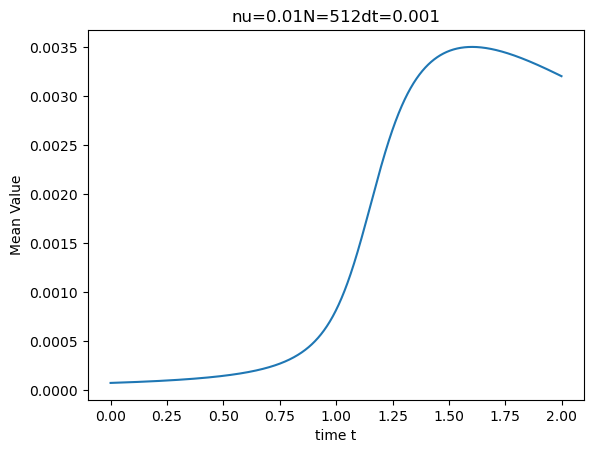

In [183]:
L=2*np.pi

N=2**9

nu=0.01

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-3)

s=10**2

no=2

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)

meanvalueplot(L,N,dt,Tmax,s,no,nu)

#it is of verey small order and initially it is zero .SO we can say we have a error of order 3

In [ ]:
#let's increase N and try 0.0001 ,the solution plot and everything


In [ ]:
L=2*np.pi

N=2**10

nu=0.0001

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-5)

s=10**4

no=4

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)


burger_solve(L,N,nu,u0k,Tmax,dt,s,no,p)

#blow up happening after 1 .Leave that part

#so in the code of burgers to accomodate a viscosity of 5*10**(-5),we used 2**14-16 points and her too less points to resolve the shock for long times

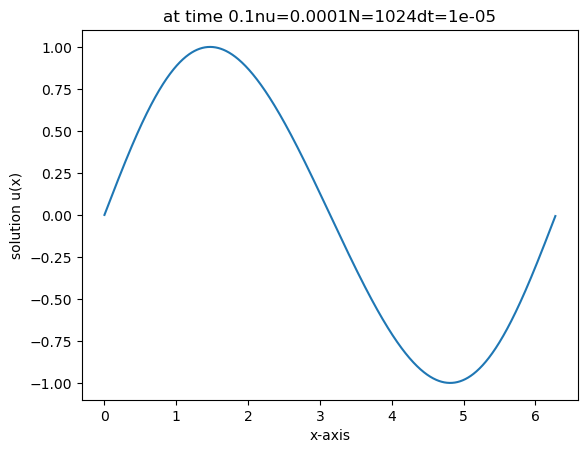

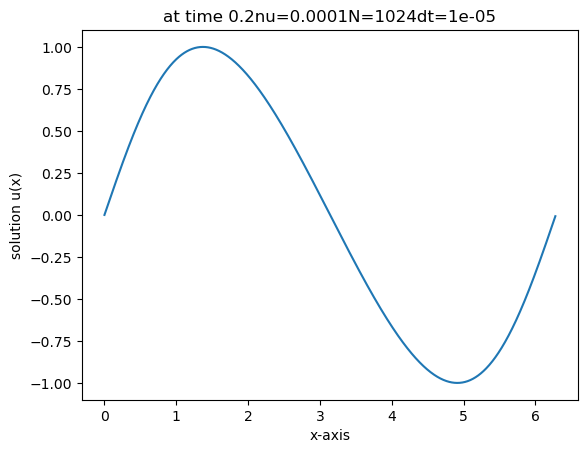

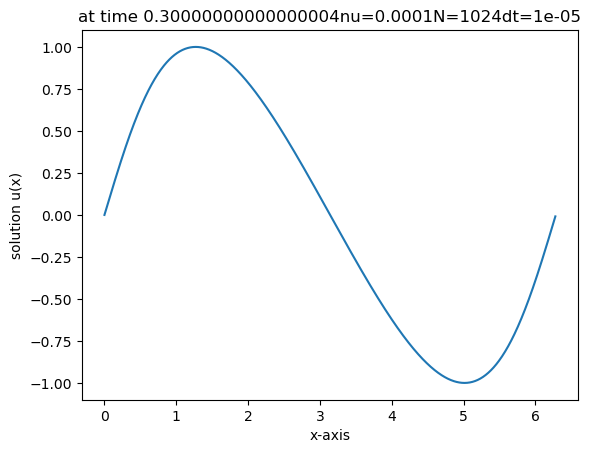

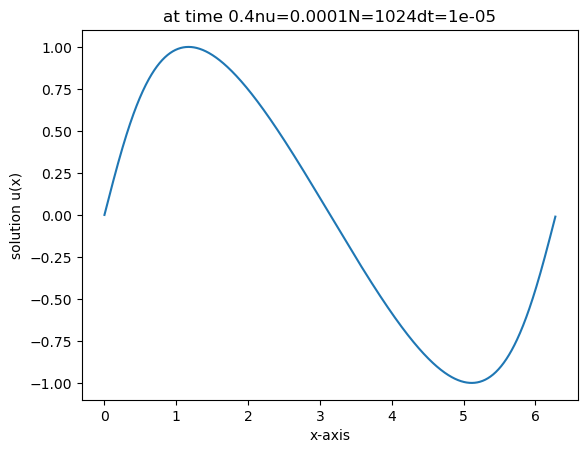

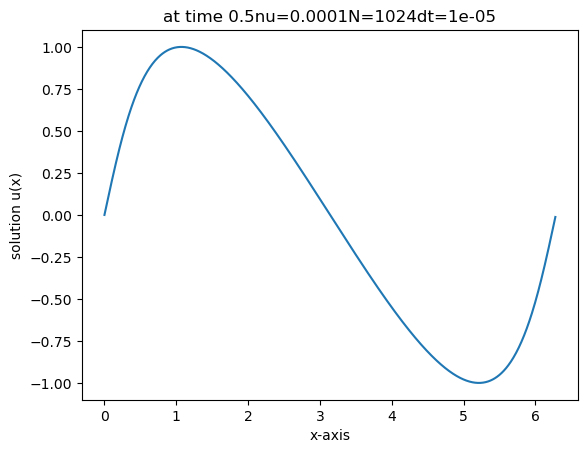

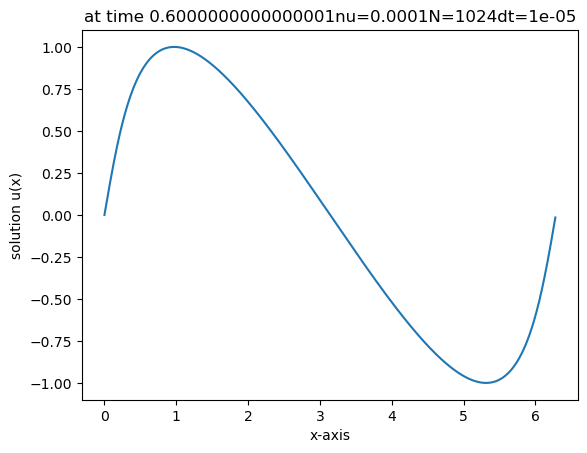

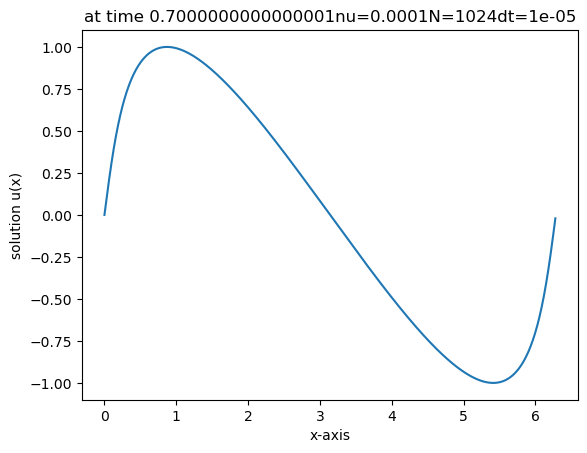

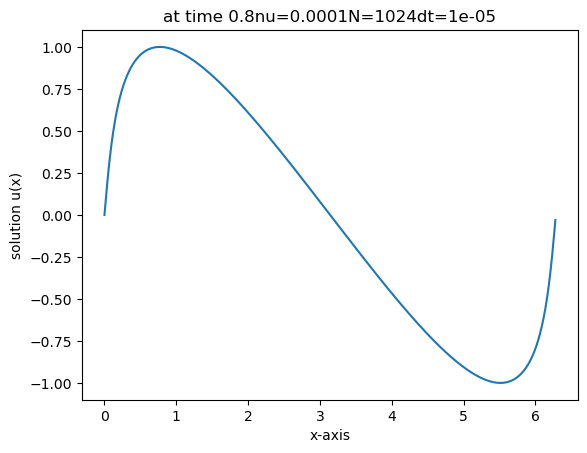

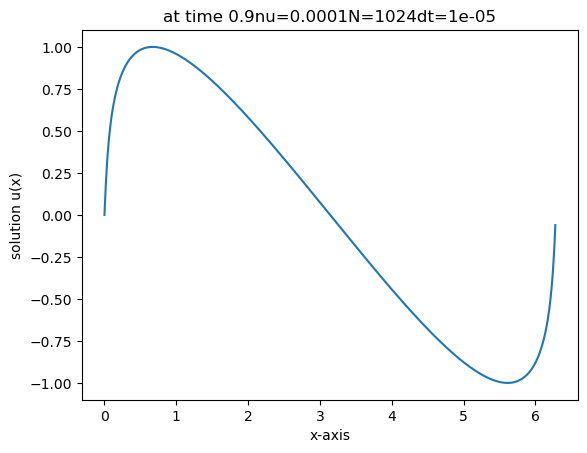

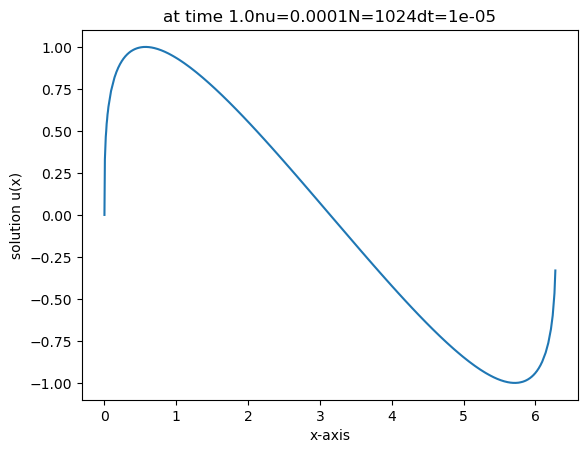

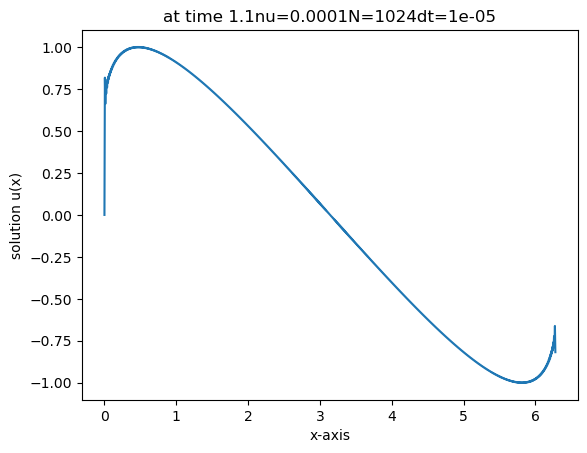

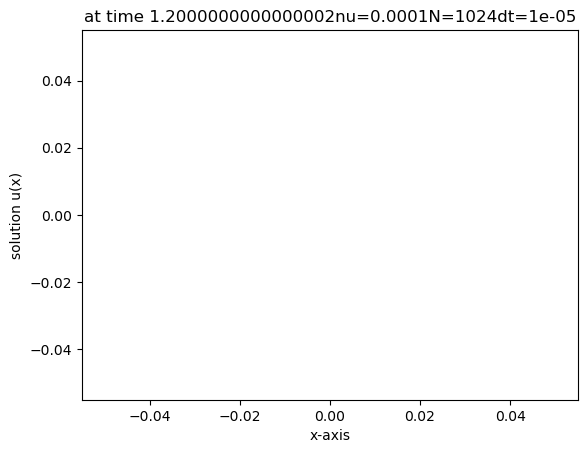

In [14]:
L=2*np.pi

N=2**10

nu=0.0001

p=1

k=fftfreq(N,1./N)

Tmax=1.3

dt=10**(-5)

s=10**4

no=4

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)

solutionplot(L,N,dt,Tmax,s,no,nu)

#solver failing after time 1.1.Reason mentioned before.


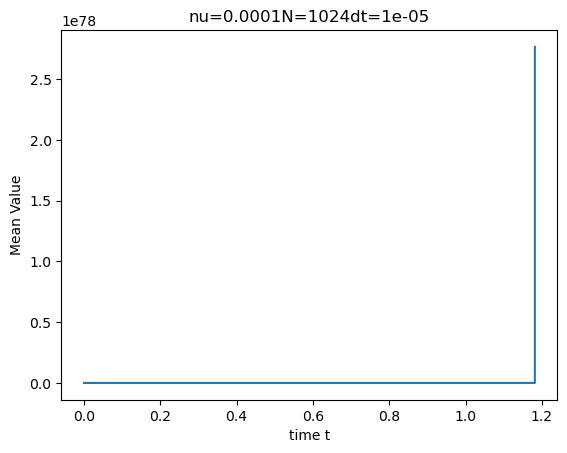

In [207]:
#plotting mean value

L=2*np.pi

N=2**10

nu=0.0001

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-5)

s=10**4

no=4

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)

meanvalueplot(L,N,dt,Tmax,s,no,nu)

#before the blow up we can see it is conserved


In [194]:
# (V) e

#plotting l2normlhs

def l2normlhsplot(L,N,dt,Tmax,s,no,nu):
    
    Nt=round(Tmax/dt) #number of time steps
    t=np.arange(0,Tmax,dt) #time points
    
    l2_norm_lhs=np.load('/localhome/souryajit/Desktop/mycodes/nlpde/l2_norm_lhs/l2normlhs'+str(no)+'.npy')
    
    plt.plot(t,l2_norm_lhs)
    plt.title('nu='+str(nu)+'N='+str(N)+'dt='+str(dt))
    plt.xlabel('time t')
    plt.ylabel('l2normlhs')
    

In [197]:
#plotting l2normlhs

def l2normrhsplot(L,N,dt,Tmax,s,no,nu):
    
    Nt=round(Tmax/dt) #number of time steps
    t=np.arange(0,Tmax,dt) #time points
    
    l2_norm_rhs=np.load('/localhome/souryajit/Desktop/mycodes/nlpde/l2_norm_rhs/l2normrhs'+str(no)+'.npy')
    
    plt.plot(t,l2_norm_rhs)
    plt.title('nu='+str(nu)+'N='+str(N)+'dt='+str(dt))
    plt.xlabel('time t')
    plt.ylabel('l2normrhs')
    

In [198]:
#plotting dl2normlhs+2*nu*l2normrhs

def verifyplot(L,N,dt,Tmax,s,no,nu):
    
    Nt=round(Tmax/dt) #number of time steps
    t=np.arange(0,Tmax,dt) #time points
    
    l2_norm_rhs=np.load('/localhome/souryajit/Desktop/mycodes/nlpde/l2_norm_rhs/l2normrhs'+str(no)+'.npy')
    dl2_norm_lhs=np.load('/localhome/souryajit/Desktop/mycodes/nlpde/dl2_norm_lhs/dl2normlhs'+str(no)+'.npy')
    
    plt.plot(t,nu*l2_norm_rhs+dl2_norm_lhs)
    plt.title('nu='+str(nu)+'N='+str(N)+'dt='+str(dt))
    plt.xlabel('time t')
    plt.ylabel('conserved quantity 0')

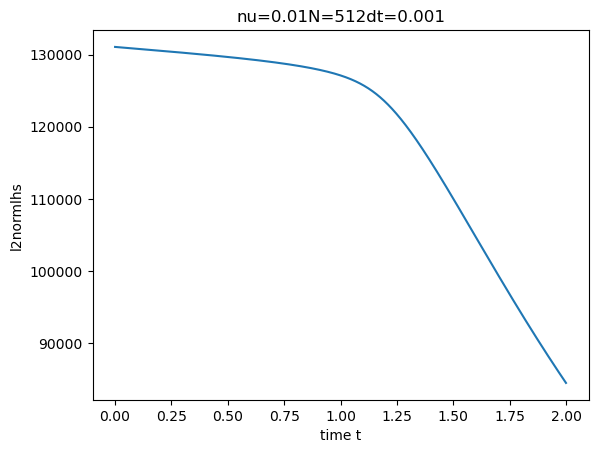

In [208]:
L=2*np.pi

N=2**9

nu=0.01

p=1

k=fftfreq(N,1./N)

Tmax=2

dt=10**(-3)

s=10**2

no=2

dx=L/N

x=np.arange(0,L,dx)

u0=np.sin(x)

u0k=fft(u0)

l2normlhsplot(L,N,dt,Tmax,s,no,nu)


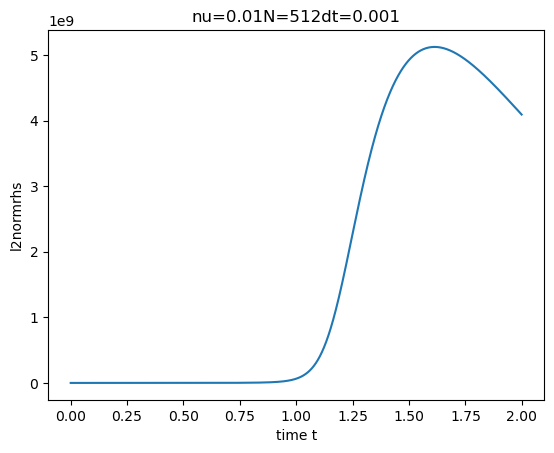

In [209]:
l2normrhsplot(L,N,dt,Tmax,s,no,nu)

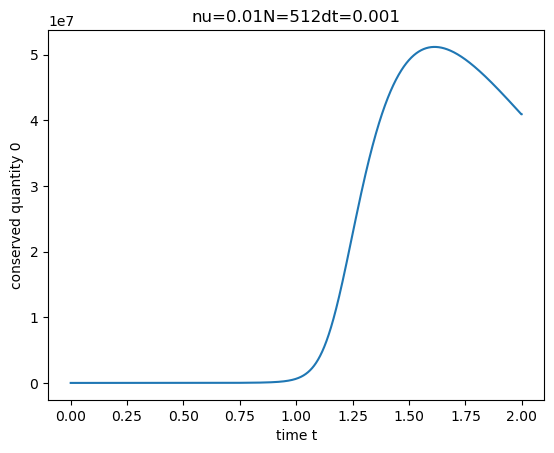

In [210]:
verifyplot(L,N,dt,Tmax,s,no,nu)

#small order starting with 0 .So it is conserved